In [1]:
from dataloader import PriceScenarioDataset
from utils import VaR, ES, score
from Discriminator import Discriminator
from Generator import Generator
from Tradining_Strategies import TradingStrategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from preprocess.acf import *
# from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from model.torch_tcn import *

In [2]:
num_epochs = 100
# nz = 3
batch_size = 128
#seq_len = 127
# clip= 0.01
lr = 0.01

noise_size=100
pnl_size=100
market_size=5

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev) 

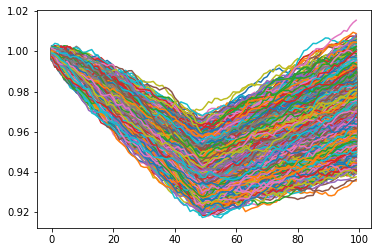

In [3]:
from scipy.stats import norm
def gen_toy_sample(x0,n):
    x0 = np.asarray(x0)
    N = norm.rvs(size=(n), scale=1e-3)
    u = np.concatenate((np.random.uniform(-1.5e-3,-8e-4,int(n/2)),np.random.uniform(4e-4,8e-4,int(n/2))))
    r = N+u
    out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out
toy_sample_n = 10000
toy_sample = []
for i in range(toy_sample_n):
    toy_sample.append(gen_toy_sample(1,100))
toy_sample = np.array(toy_sample)

toy_sample_price_scenarios = np.empty(toy_sample.shape)
for i in range(toy_sample_n):
    toy_sample_price_scenarios[i,:] = toy_sample[i,:] #np.log(toy_sample[i,:]/toy_sample[i,0])
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

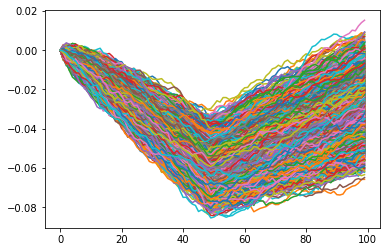

In [4]:
toy_sample_price_scenarios=np.log(toy_sample_price_scenarios[:,:]/toy_sample_price_scenarios[:,0].reshape(-1,1))
for i in range(toy_sample_n):
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

In [5]:
toy_sample_tensor = torch.tensor(toy_sample_price_scenarios).cuda()
dataloader = torch.utils.data.DataLoader(toy_sample_tensor, batch_size=batch_size,drop_last=True,shuffle=True)

In [5]:
data_df = pd.read_csv("./data/Portfolios_Formed_on_ME_daily.csv", error_bad_lines=False)

C:\Users\ytc19\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x)[0]

'0.39'

In [7]:
# lo30_df=data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x).apply(float)
# lo30_df=lo30_df.fillna(lo30_df.mean())
# lo30_data=lo30_df.to_numpy(dtype=np.float32).reshape(1,-1)
# lo30_data = torch.tensor(lo30_data,).cuda()
# dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,drop_last=True,shuffle=True)
# for i in dataloader:
#     print(i[0].shape,i[-1].shape)
#     break
# len(dataset)

In [15]:
torch.ones_like(torch.tensor((2,1)))+0

tensor([1, 1])

In [ ]:
generator = Generator(noise_size=noise_size,
                      pnl_size=pnl_size,market_size=batch_size
                     ).to(device)
discriminator = Discriminator(pnl_size=pnl_size).to(device)

In [6]:
import torch.optim as optim
from tqdm import tqdm

train = True
# batch*pnl
signal = 4e-3
trade_strategy_1 = TradingStrategy("buy-hold",10,(0,0),(signal,signal))
trade_strategy_2 = TradingStrategy("MA",10,(0,0),(signal,signal))
trade_strategy_3 = TradingStrategy("MOM",10,(0,0),(signal,signal))
if train:
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    scheduler_disc = torch.optim.lr_scheduler.CosineAnnealingLR(disc_optimizer, T_max=1000, eta_min=0)
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
    scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=1000, eta_min=0)

#     dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    c=0
    t = tqdm(range(1000))
    generator.train()
    discriminator.train()
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
#             print(data.shape)
            c+=1
#             print(idx,epoch)
            if True: #(idx<=10 and epoch ==0):
                discriminator.zero_grad()
#                 print(data)
                ps_real = data#.permute(0,2,1).squeeze(-1)
    #             score_real = data[-1].reshape(batch_size,-1)

                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()
                
                disc_loss = 0
                for trade_strategy in [trade_strategy_1,trade_strategy_2,trade_strategy_3]:

                    ts_real = trade_strategy.get_strategy_PnL(ps_real)#,torch.ones_like(ps_real))
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)#,torch.ones_like(ps_fake))

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
                    real_ve = discriminator(ts_real)
                    real_v,real_e = real_ve[:,0],real_ve[:,1]
                    if idx % 180 == 0:
                        print("disc:current fake and real ves: ",fake_ve[0],real_ve[0])


                    disc_loss += torch.mean(score(fake_v,fake_e,ps_real,0.05)) - \
                                          torch.mean(score(real_v,real_e,ps_real,0.05))

    #             print('Discriminator Loss: %.8f' % (disc_loss.item()))
                disc_loss/=3
                disc_loss.backward()

                disc_optimizer.step()
                scheduler_disc.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if True: #not (idx<=10 and epoch ==0):# or idx % 2 == 0:
                for i in range(2):
                    generator.zero_grad()
                    discriminator.zero_grad()
                    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

    #                 print(fake_ve[0],"asdsa")

                    gen_loss = -torch.mean(score(fake_v,fake_e,ps_real,0.05))

    #                 gen_loss = -torch.mean(discriminator(generator(noise)))
                    gen_loss.backward()
                    gen_optimizer.step()
                    scheduler_gen.step()
                if idx % 180 == 0:
                    print("gen:current fake ve: ",fake_ve[0])
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f"trained_generator_epoch_{epoch}.pth")

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

disc:current fake and real ves:  tensor([ 0.0068, -0.0938], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0123, -0.0948], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 0.0053, -0.0946], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0134, -0.0954], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 0.0110, -0.0926], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0138, -0.0958], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-0.6365, -0.0692], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12390.40810258 Generator Loss: 54141.16080645:   0%|             | 1/1000 [00:02<40:24,  2.43s/it]

disc:current fake and real ves:  tensor([ 228.0672, -207.9345], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31.9208, -29.6942], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 88.4033, -81.0299], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 142.4649, -130.1023], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 226.4476, -206.4718], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 170.2075, -155.3219], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 203.6299, -186.1763], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97200933.98869789 Generator Loss: 288367149.79059809:   0%|      | 2/1000 [00:04<34:34,  2.08s/it]

disc:current fake and real ves:  tensor([ 18070.1523, -17716.4434], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-10073.6807,   9344.0195], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 11586.5977, -11360.4150], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 11943.5654, -11710.3457], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 15105.4951, -14809.9463], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 13518.0068, -13253.6084], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 14782.5303, -14496.9824], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7100563525.68333149 Generator Loss: 13271349471.14216423:   0%|  | 3/1000 [00:06<32:13,  1.94s/it]

disc:current fake and real ves:  tensor([ 89965.1797, -89070.7891], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-415258.2812,  401552.0938], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 82132.9297, -81320.7969], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60823.0742, -60262.4492], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 98422.9453, -97436.4922], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 118012.0938, -116823.2734], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 102641.7031, -101605.6719], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -226369979121.55041504 Generator Loss: 150341342692.42910767:   0%| | 4/1000 [00:07<31:15,  1.88s/i

disc:current fake and real ves:  tensor([ 486756.5312, -483370.9375], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-1587540.2500,  1554095.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 121517.9609, -122454.6484], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 214778.3750, -214053.0156], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 330646.5000, -328361.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 326405.1250, -324152.7812], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 340648.2812, -338315.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1227770724586.31347656 Generator Loss: 644306791723.35058594:   0%| | 5/1000 [00:09<31:05,  1.87s/

disc:current fake and real ves:  tensor([ 1024669.3750, -1018816.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-5285577.0000,  5203337.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 247046.5938, -248863.8281], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-678415.0000,  663917.9375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 682403.3750, -678547.0625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 809936.5000, -805310.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 670371.0000, -666601.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -3303108555708.55712891 Generator Loss: 1634189896766.53808594:   1%| | 6/1000 [00:11<30:41,  1.85s

disc:current fake and real ves:  tensor([ 1228982.8750, -1222655.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-7488721.,  7387539.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1066169.0000, -1060825.3750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-192421.8906,  182723.4219], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1082093.8750, -1076596.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1182667.7500, -1176586.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1088535.8750, -1083087.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -7108133705891.43750000 Generator Loss: 3540055994756.47509766:   1%| | 7/1000 [00:13<31:04,  1.88s

disc:current fake and real ves:  tensor([ 1768527.2500, -1760333.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-8829076.,  8716514.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1441410.0000, -1435742.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 648529.1250, -651546.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1591196.3750, -1583945.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1583918.5000, -1576661.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1596184.2500, -1588830.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: 11733901089098.93359375 Generator Loss: 17278646129481.60546875:   1%| | 8/1000 [00:15<30:26,  1.84

disc:current fake and real ves:  tensor([-10497875.,  10372146.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-13620235.,  13457740.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7501828.,  7410936.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-887728.2500,  866797.1875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2475572.7500, -2465217.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1929374.1250, -1921350.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3757293.0000, -3741647.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -12730873802343.01171875 Generator Loss: 6810688124073.80273438:   1%| | 9/1000 [00:17<30:38,  1.85

disc:current fake and real ves:  tensor([ 3238663.2500, -3226216.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-21399320.,  21146296.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1844300.7500,  1811948.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-6029030.,  5954456.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2193975.0000, -2185562.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2677466.5000, -2667176.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2215140.5000, -2206406.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -24006273734200.23828125 Generator Loss: 7949108346335.20605469:   1%| | 10/1000 [00:18<30:35,  1.8

disc:current fake and real ves:  tensor([ 5432805., -5411984.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-17840140.,  17633136.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1745371.0000,  1713979.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-1132569.1250,  1107503.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2354510.5000, -2345519.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2354925.5000, -2345955.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2313089.0000, -2304578.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -22794942794419.57031250 Generator Loss: 10535570169202.60546875:   1%| | 11/1000 [00:20<30:31,  1.

disc:current fake and real ves:  tensor([ 5074466., -5055986.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-18030120.,  17821784.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4682317.,  4621149.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3084781.0000,  3040357.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2678969.5000, -2669216.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2481511.2500, -2472478.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2658006.2500, -2648423.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -10530281285850.94140625 Generator Loss: 22162774469285.83203125:   1%| | 12/1000 [00:22<30:47,  1.

disc:current fake and real ves:  tensor([-4426364.0000,  4371984.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-17622384.,  17417684.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-12992598.,  12841653.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2508017.5000,  2468095.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4066074.5000, -4051245.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2570268.7500, -2560910.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4161140.7500, -4145821.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -10680860569408.20703125 Generator Loss: 23860642118845.74609375:   1%| | 13/1000 [00:24<31:04,  1.

disc:current fake and real ves:  tensor([-47549.5703,  36689.4883], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-16693472.,  16499770.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-13515305.,  13358459.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1046393.3125,  1021175.8750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4131234.5000, -4115679.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2522812., -2513375.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4431266., -4414580.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14730328226643.35546875 Generator Loss: 9512134212224.96484375:   1%| | 14/1000 [00:26<31:10,  1.9

disc:current fake and real ves:  tensor([ 3074316.7500, -3063220.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-12739227.,  12592072.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2649264.0000,  2608047.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 333504.8125, -345286.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2552633.0000, -2543427.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2458314.7500, -2449555.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2515805.7500, -2506737.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -18825713725271.49218750 Generator Loss: 8657222571753.16308594:   2%| | 15/1000 [00:28<30:51,  1.8

disc:current fake and real ves:  tensor([ 4189766., -4174899.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-16793170.,  16600190.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-862400.3125,  838424.6875], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-507304.9375,  487518.4062], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2486612., -2477854.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2471391.7500, -2462705.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2491472.0000, -2482604.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -20003174852859.12500000 Generator Loss: 9103746658056.10742188:   2%| | 16/1000 [00:30<30:56,  1.8

disc:current fake and real ves:  tensor([ 4303454.5000, -4288153.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-19074552.,  18856890.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-573490.4375,  552154.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-1734913.5000,  1702842.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2548152.5000, -2539175.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2585638.7500, -2576491.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2554221.2500, -2545005.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -20906089260509.10546875 Generator Loss: 9763064150674.51562500:   2%| | 17/1000 [00:32<30:42,  1.8

disc:current fake and real ves:  tensor([ 4006180.0000, -3992052.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-19670136.,  19450632.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1153008.7500, -1158053.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-1979115.3750,  1945002.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2625970.2500, -2616882.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2669019.2500, -2659653.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2628702.7500, -2619340.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -25667699264272.95312500 Generator Loss: 11252992876770.43359375:   2%| | 18/1000 [00:33<30:39,  1.

disc:current fake and real ves:  tensor([ 4142726., -4127135.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-19848150.,  19643744.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2559191.7500, -2551166.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-414759.9062,  396829.4375], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2842490.2500, -2831987.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2814631.7500, -2804114.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2830286.2500, -2820027.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -31580543820814.42578125 Generator Loss: 15062359504457.99023438:   2%| | 19/1000 [00:35<30:11,  1.

disc:current fake and real ves:  tensor([ 4618685.5000, -4601320.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-26058468.,  25798000.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3187876.5000, -3176267.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-3145473.5000,  3101926.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3281241.2500, -3269120.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3358635.0000, -3346016.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3276936.5000, -3264843.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -43809652246950.53906250 Generator Loss: 22144501418820.34765625:   2%| | 20/1000 [00:37<29:58,  1.

disc:current fake and real ves:  tensor([ 5460493.5000, -5439809.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-19062762.,  18879408.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3483427.5000, -3472196.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2826969.7500, -2821021.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3983524.7500, -3968643.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3945977.7500, -3931216.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3991976.5000, -3977198.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -130574355699537.59375000 Generator Loss: 87944933472848.21875000:   2%| | 21/1000 [00:39<29:46,  1

disc:current fake and real ves:  tensor([ 12373539., -12330479.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-29152768.,  28899342.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-17875120.,  17717706.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1799060.3750, -1806121.6250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6923512.5000, -6899422.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 5272001.5000, -5253796.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6479472.5000, -6457499.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -140681521181827.07812500 Generator Loss: 73894026383515.50000000:   2%| | 22/1000 [00:41<29:33,  1

disc:current fake and real ves:  tensor([ 13901607., -13862167.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-50714772.,  50273408.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7817395.0000,  7730611.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-6598651.5000,  6519609.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6945559.5000, -6925860.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 6814540.0000, -6795214.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6722075., -6703197.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -177822431235391.31250000 Generator Loss: 121741914838209.40625000:   2%| | 23/1000 [00:42<29:28,  

disc:current fake and real ves:  tensor([ 9764843., -9749603.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-65287848.,  64746632.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-16640264.,  16473606.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3324626.5000,  3254391.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9706036., -9690887.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8349811.5000, -8336974.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8806801., -8792966.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -507662834532812.56250000 Generator Loss: 199480477775503.68750000:   2%| | 24/1000 [00:44<29:44,  

disc:current fake and real ves:  tensor([ 19782192., -19772274.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1919e+08,  1.1836e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-31802560.,  31548706.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-16963106.,  16798574.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 14162185., -14155098.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 11800420., -11794527.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 15533295., -15525538.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1071456266745871.50000000 Generator Loss: 973018626001411.37500000:   2%| | 25/1000 [00:46<29:44, 

disc:current fake and real ves:  tensor([ 22946512., -22933502.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6290e+08,  1.6189e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-31544546.,  31289394.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-21881460.,  21680550.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 17925774., -17915622.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 16673553., -16664403.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 17292566., -17282708.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2251172915094312.50000000 Generator Loss: 1337446533591299.00000000:   3%| | 26/1000 [00:48<29:36,

disc:current fake and real ves:  tensor([ 36057400., -36051028.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8206e+08,  1.8104e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-70139736.,  69657776.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-19063560.,  18857326.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 35082840., -35076632.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 22926992., -22924432.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 34715520., -34709372.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3207883648274246.00000000 Generator Loss: 1696353707354848.75000000:   3%| | 27/1000 [00:50<29:24,

disc:current fake and real ves:  tensor([ 32182568., -32194168.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4041e+08,  2.3910e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-70181992.,  69694480.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-25535074.,  25259996.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 32632318., -32643308.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29849106., -29860472.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 32757516., -32767500.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4824095987350762.00000000 Generator Loss: 1833434530789916.75000000:   3%| | 28/1000 [00:52<29:26,

disc:current fake and real ves:  tensor([ 40951036., -40971628.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8394e+08,  3.8202e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1178e+08,  1.1112e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-71058808.,  70567952.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 40076788., -40096936.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36623764., -36642716.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 41492088., -41516036.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8323184956175593.00000000 Generator Loss: 1165624061841622.50000000:   3%| | 29/1000 [00:53<29:26,

disc:current fake and real ves:  tensor([ 50848264., -50874220.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2935e+08,  5.2687e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-97148280.,  96556344.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-87241688.,  86687952.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 41696904., -41719060.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 40588876., -40610748.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 45806060., -45830076.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11663216640259172.00000000 Generator Loss: 3047614124006876.00000000:   3%| | 30/1000 [00:55<29:11

disc:current fake and real ves:  tensor([ 51558600., -51581888.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8248e+08,  4.8040e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0360e+08,  1.0299e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-81715824.,  81194736.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 46358752., -46380828.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 42473152., -42512936.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 47459912., -47476248.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14063094329603260.00000000 Generator Loss: -303998089363292.75000000:   3%| | 31/1000 [00:57<29:17

disc:current fake and real ves:  tensor([ 59387640., -59381140.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1903e+08,  5.1687e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-53666992.,  53299396.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1889e+08,  1.1827e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-55649228.,  55274592.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32903782., -32955246.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-55876048.,  55501216.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17964075109233380.00000000 Generator Loss: -523420640105599.68750000:   3%| | 32/1000 [00:59<29:10

disc:current fake and real ves:  tensor([ 62404860., -62402392.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.6737e+08,  9.6345e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-70528872.,  70105944.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9770e+08,  2.9644e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-70024832.,  69604056.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 64734508., -64731944.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-73162656.,  72723728.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20737045787691548.00000000 Generator Loss: -626571802694504.12500000:   3%| | 33/1000 [01:01<29:02

disc:current fake and real ves:  tensor([ 65095996., -65120928.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1939e+08,  8.1612e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-84933328.,  84449120.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5013e+08,  1.4940e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-79155280.,  78691424.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 44770156., -44827796.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-81026824.,  80561312.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22840312382995412.00000000 Generator Loss: -813947165352167.75000000:   3%| | 34/1000 [01:02<28:46

disc:current fake and real ves:  tensor([ 66308924., -66357332.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6186e+08,  7.5888e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-90567296.,  90058592.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6397e+08,  1.6321e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-90614592.,  90105912.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 197647.6719, -410813.7812], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-90691480.,  90176520.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25618461054293600.00000000 Generator Loss: -902399081656153.62500000:   4%| | 35/1000 [01:04<28:40

disc:current fake and real ves:  tensor([ 67359856., -67428656.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5883e+08,  7.5586e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-95517912.,  94981480.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2479e+08,  1.2415e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-95568504.,  95032128.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-39262100.,  38897148.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-95606032.,  95070040.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24289171182345072.00000000 Generator Loss: -957643432679254.37500000:   4%| | 36/1000 [01:06<28:39

disc:current fake and real ves:  tensor([ 67005224., -67086304.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4395e+08,  7.4107e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-98217424.,  97668648.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8898e+08,  1.8813e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-98258688.,  97709976.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32090318., -32239588.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-98282208.,  97732144.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15355433517902332.00000000 Generator Loss: 7794098181188218.00000000:   4%| | 37/1000 [01:08<28:37

disc:current fake and real ves:  tensor([-6.3290e+08,  6.3045e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.9516e+08,  6.9247e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4072e+08,  2.3968e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6575e+08,  1.6498e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 66132664., -66214284.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-18893280.,  18590402.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 79039864., -79139344.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26647336024271496.00000000 Generator Loss: 6202285717689365.00000000:   4%| | 38/1000 [01:09<28:27

disc:current fake and real ves:  tensor([ 87508512., -87615152.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0151e+09,  1.0112e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1955e+08,  2.1857e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1844e+08,  3.1717e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 59679052., -59752780.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 68366936., -68450312.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 61003784., -61078940.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23940881084811160.00000000 Generator Loss: 8051461566560644.00000000:   4%| | 39/1000 [01:11<28:29

disc:current fake and real ves:  tensor([ 67452952., -67532640.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.2144e+08,  9.1788e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2368e+08,  4.2204e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6537e+08,  2.6428e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 76756728., -76847344.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60339076., -60410660.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 74896688., -74985088.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25401519283775344.00000000 Generator Loss: 7893636422340871.00000000:   4%| | 40/1000 [01:13<29:08

disc:current fake and real ves:  tensor([ 81581016., -81681416.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8717e+08,  9.8334e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6329e+08,  3.6186e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2933e+08,  2.2835e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 70239688., -70326144.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 59757524., -59832104.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 65271208., -65350756.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26333386903957800.00000000 Generator Loss: 2786669618359349.00000000:   4%| | 41/1000 [01:15<29:02

disc:current fake and real ves:  tensor([ 72077088., -72169400.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6198e+08,  7.5903e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6109e+08,  1.6032e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8029e+08,  1.7947e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-15085250.,  14788651.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5686069., -5920654.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 21147252., -21331700.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23086012654331856.00000000 Generator Loss: 4737152046174981.00000000:   4%| | 42/1000 [01:17<29:16

disc:current fake and real ves:  tensor([-1.6141e+08,  1.6064e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.0915e+08,  9.0570e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5751e+08,  2.5644e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4754e+08,  2.4651e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 60403772., -60483788.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 63081784., -63165364.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 58478572., -58555812.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24157654514192808.00000000 Generator Loss: -935142042937800.37500000:   4%| | 43/1000 [01:19<28:59

disc:current fake and real ves:  tensor([-1.9329e+08,  1.9243e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1306e+09,  1.1262e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1145e+08,  1.1085e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0811e+08,  3.0687e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-95806496.,  95253184.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 67303792., -67410544.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-97131616.,  96575616.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25064760888608320.00000000 Generator Loss: -1152318047903762.50000000:   4%| | 44/1000 [01:20<28:4

disc:current fake and real ves:  tensor([-1.9609e+08,  1.9521e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0120e+09,  1.0082e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1081e+08,  1.1019e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6313e+08,  2.6203e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0769e+08,  1.0708e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 64891316., -65044684.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0777e+08,  1.0716e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27416767341533976.00000000 Generator Loss: -1302218972754803.00000000:   4%| | 45/1000 [01:22<28:3

disc:current fake and real ves:  tensor([-2.0611e+08,  2.0519e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3017e+08,  7.2744e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1767e+08,  1.1700e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8377e+08,  1.8290e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1448e+08,  1.1382e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-30333200.,  29905066.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1456e+08,  1.1390e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28669413396998436.00000000 Generator Loss: -1509638153641738.50000000:   5%| | 46/1000 [01:24<28:1

disc:current fake and real ves:  tensor([-2.2010e+08,  2.1911e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0171e+09,  1.0133e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2658e+08,  1.2584e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6414e+08,  1.6326e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2326e+08,  1.2254e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3475711.5000, -3911020.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2336e+08,  1.2263e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -35466676422536068.00000000 Generator Loss: -1788156554343308.75000000:   5%| | 47/1000 [01:26<28:1

disc:current fake and real ves:  tensor([-2.3478e+08,  2.3374e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0398e+09,  1.0361e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3760e+08,  1.3679e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2430e+08,  3.2303e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3427e+08,  1.3347e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 57679964., -58067492.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3443e+08,  1.3363e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -40926510489429184.00000000 Generator Loss: -2187850291369418.25000000:   5%| | 48/1000 [01:27<28:0

disc:current fake and real ves:  tensor([-2.2813e+08,  2.2704e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2630e+09,  1.2586e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5092e+08,  1.5000e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1215e+08,  4.1063e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4789e+08,  1.4697e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 59601540., -60156572.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4964e+08,  1.4872e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46985031781774800.00000000 Generator Loss: -2705052466959990.00000000:   5%| | 49/1000 [01:29<28:0

disc:current fake and real ves:  tensor([-2.3913e+08,  2.3795e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1391e+09,  1.1352e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6830e+08,  1.6726e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1317e+08,  3.1184e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6521e+08,  1.6417e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 13949992., -14686069.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6544e+08,  1.6440e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -56606433382664160.00000000 Generator Loss: -3405964376202324.00000000:   5%| | 50/1000 [01:31<28:1

disc:current fake and real ves:  tensor([-2.5805e+08,  2.5675e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2647e+09,  1.2605e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8850e+08,  1.8730e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5066e+08,  3.4920e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8515e+08,  1.8396e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8379020.5000, -9309648.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8542e+08,  1.8423e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -71146718445728872.00000000 Generator Loss: -4285229455612532.50000000:   5%| | 51/1000 [01:33<28:0

disc:current fake and real ves:  tensor([-2.7519e+08,  2.7375e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6081e+09,  1.6030e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1142e+08,  2.1005e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0879e+08,  5.0706e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0772e+08,  2.0635e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 54665616., -55850204.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0802e+08,  2.0665e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -91308326539596688.00000000 Generator Loss: -5138780394183263.00000000:   5%| | 52/1000 [01:35<28:0

disc:current fake and real ves:  tensor([-2.9643e+08,  2.9480e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8037e+09,  1.7983e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4683e+08,  2.4523e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2208e+08,  6.2019e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2227e+08,  2.2069e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 59009712., -60646476.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2558e+08,  2.2398e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110518307342837696.00000000 Generator Loss: -6735276240114503.00000000:   5%| | 53/1000 [01:36<28:

disc:current fake and real ves:  tensor([-3.0419e+08,  3.0234e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8095e+09,  1.8043e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6497e+08,  2.6313e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3671e+08,  5.3481e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6044e+08,  2.5860e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 50996768., -52794728.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6078e+08,  2.5894e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -136076670472943056.00000000 Generator Loss: -8419493248795328.00000000:   5%| | 54/1000 [01:38<28:

disc:current fake and real ves:  tensor([-3.2724e+08,  3.2513e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9029e+09,  1.8976e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9123e+08,  2.8910e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3482e+08,  5.3275e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9123e+08,  2.8910e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-18885372.,  16739112.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9161e+08,  2.8946e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161690084239130464.00000000 Generator Loss: -10061404813524544.00000000:   6%| | 55/1000 [01:40<28

disc:current fake and real ves:  tensor([-3.5463e+08,  3.5220e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3747e+09,  2.3683e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1843e+08,  3.1596e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2780e+08,  6.2552e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1843e+08,  3.1596e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 19480186., -22074214.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1875e+08,  3.1628e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -189129424124457984.00000000 Generator Loss: -11667043017080048.00000000:   6%| | 56/1000 [01:42<28

disc:current fake and real ves:  tensor([-3.8248e+08,  3.7970e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8495e+09,  2.8420e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4300e+08,  3.4015e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.9729e+08,  8.9490e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4300e+08,  3.4015e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 56977780., -60389556.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4331e+08,  3.4044e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -216893951377839776.00000000 Generator Loss: -13133143316127600.00000000:   6%| | 57/1000 [01:44<27

disc:current fake and real ves:  tensor([-4.0657e+08,  4.0346e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9606e+09,  1.9555e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6400e+08,  3.6079e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7152e+08,  4.6845e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6400e+08,  3.6079e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4935e+08,  2.4604e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.6425e+08,  3.6102e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -232493167283120512.00000000 Generator Loss: -14368805411860768.00000000:   6%| | 58/1000 [01:45<27

disc:current fake and real ves:  tensor([-4.2063e+08,  4.1718e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3858e+09,  2.3797e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8085e+08,  3.7727e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8050e+08,  6.7747e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8085e+08,  3.7727e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-55930332.,  52070560.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.8106e+08,  3.7750e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -254146461431678400.00000000 Generator Loss: -15325444476327626.00000000:   6%| | 59/1000 [01:47<27

disc:current fake and real ves:  tensor([-4.3796e+08,  4.3426e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8351e+09,  2.8281e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9344e+08,  3.8959e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3025e+08,  8.2751e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9344e+08,  3.8959e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 52511524., -56925820.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.9362e+08,  3.8974e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -266603666813374624.00000000 Generator Loss: -16001156701522752.00000000:   6%| | 60/1000 [01:49<27

disc:current fake and real ves:  tensor([-4.4319e+08,  4.3923e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1452e+09,  2.1398e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0207e+08,  3.9796e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3605e+08,  5.3230e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0207e+08,  3.9796e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5293e+08,  2.4870e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.0217e+08,  3.9807e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -256665325706753344.00000000 Generator Loss: -16411312852692636.00000000:   6%| | 61/1000 [01:51<27

disc:current fake and real ves:  tensor([-4.2324e+08,  4.1908e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0108e+09,  2.0057e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0734e+08,  4.0307e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5173e+08,  5.4795e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0734e+08,  4.0307e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4113e+08,  2.3677e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.0743e+08,  4.0317e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 410051644828498688.00000000 Generator Loss: 43709550449555664.00000000:   6%| | 62/1000 [01:52<27:3

disc:current fake and real ves:  tensor([ 1.5882e+08, -1.7322e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6339e+09,  2.6274e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4064e+09,  5.3931e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.0819e+08,  9.0556e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8781e+08, -2.0484e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 55174068., -60241628.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6249e+08, -1.7721e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -216725862561919872.00000000 Generator Loss: 7244741718960063.00000000:   6%| | 63/1000 [01:54<27:4

disc:current fake and real ves:  tensor([ 83403384., -90947136.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1076e+09,  3.1000e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6137e+09,  1.6097e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0302e+09,  1.0277e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 71958728., -78467744.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 59246784., -64614608.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 83851576., -91434856.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -65369232958490824.00000000 Generator Loss: 10521626686140326.00000000:   6%| | 64/1000 [01:56<27:3

disc:current fake and real ves:  tensor([-1.1054e+09,  1.1026e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9062e+09,  2.8990e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9521e+09,  1.9472e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.4375e+08,  9.4111e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 83814248., -91395008.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 57171200., -62386596.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 90390984., -98565256.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -205055222714219776.00000000 Generator Loss: 10104613481051918.00000000:   6%| | 65/1000 [01:58<27:

disc:current fake and real ves:  tensor([-91649192.,  87658136.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6618e+09,  2.6552e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7377e+09,  1.7333e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3502e+08,  4.3130e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 79267648., -86435728.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4447e+08,  3.4053e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 79479040., -86667456.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -250127224942169856.00000000 Generator Loss: 5231834866131731.00000000:   7%| | 66/1000 [01:59<27:2

disc:current fake and real ves:  tensor([-3.3275e+08,  3.2888e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7522e+09,  2.7453e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0947e+09,  1.0919e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7669e+08,  8.7393e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 59193452., -64544268.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 54903224., -59946432.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 62539004., -68192856.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -265946104462438688.00000000 Generator Loss: 5858808536127317.00000000:   7%| | 67/1000 [02:01<27:2

disc:current fake and real ves:  tensor([ 1.1419e+08, -1.2448e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2682e+09,  3.2601e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4310e+09,  1.4275e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0117e+09,  1.0091e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 68296856., -74459280.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 58032160., -63278828.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 57537660., -62731036.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -259131604098035712.00000000 Generator Loss: 5070222498187353.00000000:   7%| | 68/1000 [02:03<27:2

disc:current fake and real ves:  tensor([ 1.0617e+08, -1.1570e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4714e+09,  3.4629e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0057e+09,  1.0032e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8066e+08,  6.7781e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 57534176., -62715232.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-79979504.,  75594736.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 57867936., -63070520.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -299850799891699456.00000000 Generator Loss: -13504508654773448.00000000:   7%| | 69/1000 [02:05<27

disc:current fake and real ves:  tensor([ 88123936., -96046904.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4191e+09,  2.4131e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0387e+08,  4.9986e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1833e+08,  7.1492e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4306e+08,  3.3870e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1734e+08,  1.1254e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1200e+08,  3.0757e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -292128331216256320.00000000 Generator Loss: -18417856815816428.00000000:   7%| | 70/1000 [02:06<27

disc:current fake and real ves:  tensor([ 67246632., -73384208.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7664e+09,  3.7573e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4713e+08,  4.4286e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2002e+09,  1.1973e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3133e+08,  4.2702e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 64609692., -70491744.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3143e+08,  4.2712e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -333370217245038016.00000000 Generator Loss: -20084419907454256.00000000:   7%| | 71/1000 [02:08<27

disc:current fake and real ves:  tensor([ 68613288., -74990736.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8345e+09,  2.8276e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5884e+08,  4.5445e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1161e+08,  8.0837e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5109e+08,  4.4668e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-72759936.,  67670944.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5133e+08,  4.4693e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -352845405632615424.00000000 Generator Loss: -21933154022538436.00000000:   7%| | 72/1000 [02:10<27

disc:current fake and real ves:  tensor([ 70532168., -77229760.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2880e+09,  3.2803e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7858e+08,  4.7408e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0493e+09,  1.0468e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7059e+08,  4.6607e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 61799100., -67717968.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.7084e+08,  4.6630e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -397489449516162688.00000000 Generator Loss: -24170819600518204.00000000:   7%| | 73/1000 [02:12<27

disc:current fake and real ves:  tensor([ 73139536., -80276424.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2416e+09,  2.2363e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0227e+08,  4.9755e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7727e+08,  5.7318e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.9399e+08,  4.8925e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9525e+08,  3.9067e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.9434e+08,  4.8957e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -407913785115602048.00000000 Generator Loss: -26908683067853340.00000000:   7%| | 74/1000 [02:14<28

disc:current fake and real ves:  tensor([ 76451376., -84129664.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2948e+09,  3.2872e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.2994e+08,  5.2494e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6939e+08,  8.6640e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.2126e+08,  5.1623e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4786e+08,  1.4250e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.2160e+08,  5.1658e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -155079324685904480.00000000 Generator Loss: 14003140014008550.00000000:   8%| | 75/1000 [02:16<28:

disc:current fake and real ves:  tensor([-1.0018e+09,  9.9919e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0396e+09,  3.0327e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1025e+09,  2.0977e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6886e+08,  5.6423e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4299e+07, -1.0378e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1893e+08,  5.1409e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 88413584., -97311200.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -359275830192256832.00000000 Generator Loss: 12532944621251418.00000000:   8%| | 76/1000 [02:17<28:

disc:current fake and real ves:  tensor([-7.7270e+08,  7.6937e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3015e+09,  3.2940e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8641e+09,  1.8599e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8825e+08,  9.8537e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0040e+08, -1.0984e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3220e+08,  1.2591e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.1967e+07, -1.0061e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -295753232616637440.00000000 Generator Loss: 30528152585591316.00000000:   8%| | 77/1000 [02:19<27:

disc:current fake and real ves:  tensor([-6.7332e+08,  6.6979e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4402e+09,  3.4327e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5157e+09,  2.5102e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1253e+09,  1.1228e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3752e+08, -1.4972e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-21385494.,  14267365.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4281e+08, -1.5548e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57173765105942752.00000000 Generator Loss: 69701742191957456.00000000:   8%| | 78/1000 [02:21<27:4

disc:current fake and real ves:  tensor([-2.0059e+08,  1.9588e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0980e+09,  4.0894e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1939e+09,  4.1851e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1415e+09,  1.1390e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2756e+08, -2.4693e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-93337624.,  85930632.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3581e+08, -2.5585e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -593401043867853568.00000000 Generator Loss: 35976976846131276.00000000:   8%| | 79/1000 [02:23<27:

disc:current fake and real ves:  tensor([ 1.7795e+08, -1.9234e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5629e+09,  4.5530e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7801e+09,  2.7740e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1918e+09,  1.1891e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9433e+08, -2.1004e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 23860214., -32562214.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6943e+08, -1.8312e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -660395811771420544.00000000 Generator Loss: 30157524586234336.00000000:   8%| | 80/1000 [02:25<27:

disc:current fake and real ves:  tensor([ 1.7228e+08, -1.8580e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4817e+09,  3.4743e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5805e+09,  1.5770e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.2481e+08,  9.2086e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3984e+08, -1.5084e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5515e+08,  4.4853e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3563e+08, -1.4635e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -764393106968511744.00000000 Generator Loss: 28394612798170348.00000000:   8%| | 81/1000 [02:26<27:

disc:current fake and real ves:  tensor([ 1.6026e+08, -1.7267e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5396e+09,  4.5301e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5784e+09,  1.5751e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3812e+09,  1.3783e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4381e+08, -1.5502e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28096350., -37816004.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5480e+08, -1.6678e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -714958132317163776.00000000 Generator Loss: -321595126047878.68750000:   8%| | 82/1000 [02:28<27:3

disc:current fake and real ves:  tensor([-1.5513e+09,  1.5481e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6237e+09,  4.6144e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4444e+09,  1.4414e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3173e+09,  1.3146e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-31970450.,  22261312.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7359e+08,  1.6470e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0444e+08,  9.5126e+07], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -863869292991350528.00000000 Generator Loss: -45628490314469056.00000000:   8%| | 83/1000 [02:30<27

disc:current fake and real ves:  tensor([-1.1933e+09,  1.1895e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1497e+09,  5.1393e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.0159e+08,  8.9615e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3981e+09,  1.3952e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.1246e+08,  7.0600e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2225e+08,  1.1271e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9970e+08,  6.9315e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -871268735893648000.00000000 Generator Loss: -64959546604719880.00000000:   8%| | 84/1000 [02:32<27

disc:current fake and real ves:  tensor([-1.0860e+09,  1.0807e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3585e+09,  5.3476e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4792e+08,  8.4136e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8581e+09,  1.8543e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0335e+08,  7.9658e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5621e+08, -1.6906e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.0350e+08,  7.9674e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -913061209534416000.00000000 Generator Loss: -68644968377748920.00000000:   8%| | 85/1000 [02:34<27

disc:current fake and real ves:  tensor([-1.0943e+09,  1.0886e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3312e+09,  5.3207e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4553e+08,  8.3847e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5679e+09,  1.5647e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.3214e+08,  8.2501e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1593e+08, -1.2761e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.3223e+08,  8.2507e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -986894634972695168.00000000 Generator Loss: -70056355148659456.00000000:   9%| | 86/1000 [02:35<27

disc:current fake and real ves:  tensor([-1.0576e+09,  1.0513e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5908e+09,  5.5798e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.5427e+08,  8.4688e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6176e+09,  1.6143e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4072e+08,  8.3327e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4105e+08, -1.5342e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.4083e+08,  8.3336e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -973515497423448064.00000000 Generator Loss: 39017281189535168.00000000:   9%| | 87/1000 [02:37<27:

disc:current fake and real ves:  tensor([-4.0672e+08,  3.9700e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9912e+09,  4.9815e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1829e+09,  2.1786e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5742e+09,  1.5702e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6827e+08, -1.8294e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-16130347.0000,   4586621.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7447e+08, -1.8969e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -933902736702381824.00000000 Generator Loss: 50224469022779656.00000000:   9%| | 88/1000 [02:39<26:

disc:current fake and real ves:  tensor([ 2.3960e+08, -2.6043e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9528e+09,  4.9430e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2360e+09,  2.2315e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1109e+09,  1.1046e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7230e+08, -1.8729e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5419e+08,  4.4483e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8682e+08, -2.0307e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -955223346517434112.00000000 Generator Loss: 45153395944437120.00000000:   9%| | 89/1000 [02:41<26:

disc:current fake and real ves:  tensor([ 1.6236e+08, -1.7647e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6738e+09,  5.6626e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1549e+09,  2.1506e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7231e+09,  1.7196e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6877e+08, -1.8343e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2798e+08, -1.4029e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6285e+08, -1.7700e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -985967866242676992.00000000 Generator Loss: 35035194643481932.00000000:   9%| | 90/1000 [02:42<27:

disc:current fake and real ves:  tensor([ 2.5194e+08, -2.7384e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6027e+09,  5.5916e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8424e+09,  1.8387e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5201e+09,  1.5159e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5747e+08, -1.7119e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-19947778.0000,   8281257.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6224e+08, -1.7635e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -798627625280679168.00000000 Generator Loss: 78996586455474448.00000000:   9%| | 91/1000 [02:44<27:

disc:current fake and real ves:  tensor([-4.7498e+08,  4.6552e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2832e+09,  5.2727e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8171e+09,  2.8115e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6305e+09,  1.6268e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9874e+08, -2.1599e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 81817416., -93909992.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9807e+08, -2.1527e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1047186606966892672.00000000 Generator Loss: -2567503802338459.00000000:   9%| | 92/1000 [02:46<26

disc:current fake and real ves:  tensor([ 2.1558e+08, -2.3426e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8422e+09,  4.8325e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8471e+09,  1.8434e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1516e+09,  1.1455e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5406e+08, -1.6750e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3484e+08,  4.2523e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8976e+08, -2.0621e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -996515840915857024.00000000 Generator Loss: 876730382877111.37500000:   9%| | 93/1000 [02:48<26:47

disc:current fake and real ves:  tensor([-4.4870e+08,  4.3891e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9372e+09,  5.9252e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6951e+09,  1.6916e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6742e+09,  1.6706e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 59263040., -71397648.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1556e+08, -1.2787e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9435e+08,  1.8348e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1049864214089126400.00000000 Generator Loss: -39927608995209312.00000000:   9%| | 94/1000 [02:50<2

disc:current fake and real ves:  tensor([-1.2953e+09,  1.2899e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5407e+09,  6.5277e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0975e+09,  1.0909e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0127e+09,  2.0086e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1467e+08,  6.0571e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6565e+08, -1.8004e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4935e+08,  6.4056e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1084927238088756480.00000000 Generator Loss: -49912871160148248.00000000:  10%| | 95/1000 [02:51<2

disc:current fake and real ves:  tensor([-8.6010e+08,  8.5204e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5607e+09,  6.5476e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.7601e+08,  9.6847e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3476e+09,  2.3429e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.5115e+08,  7.4260e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7716e+08, -1.9270e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4884e+08,  6.3980e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1055106559903652864.00000000 Generator Loss: -66529642390705624.00000000:  10%| | 96/1000 [02:53<2

disc:current fake and real ves:  tensor([-1.6246e+09,  1.6197e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1590e+09,  5.1490e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.5005e+08,  9.4186e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6240e+09,  1.6192e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2003e+08,  8.1126e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3103677.7500, -9336905.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.2012e+08,  8.1131e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1142295717695445120.00000000 Generator Loss: -74424057269709296.00000000:  10%| | 97/1000 [02:55<2

disc:current fake and real ves:  tensor([-1.5112e+09,  1.5049e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7041e+09,  6.6910e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.3364e+08,  9.2461e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5026e+09,  1.4961e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6795e+08,  8.5864e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0539e+08,  1.9332e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.6822e+08,  8.5892e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1294253836298465792.00000000 Generator Loss: -82767488721203968.00000000:  10%| | 98/1000 [02:57<2

disc:current fake and real ves:  tensor([-1.3412e+09,  1.3333e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4881e+09,  5.4776e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.2966e+08,  9.1982e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6040e+09,  1.5974e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.1471e+08,  9.0482e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-75602008.,  62294692.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.1505e+08,  9.0512e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1365894684173726208.00000000 Generator Loss: -87576393540137344.00000000:  10%| | 99/1000 [02:58<2

disc:current fake and real ves:  tensor([-1.3742e+09,  1.3655e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6398e+09,  5.6291e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.5666e+08,  9.4598e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8776e+09,  1.8712e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.4119e+08,  9.3045e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2172e+08, -1.3671e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.4155e+08,  9.3083e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1455453736326534656.00000000 Generator Loss: -93163178209747808.00000000:  10%| | 100/1000 [03:00<

disc:current fake and real ves:  tensor([-1.2798e+09,  1.2696e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7880e+09,  5.7772e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.9525e+08,  9.8363e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5085e+09,  1.4992e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.6801e+08,  9.5628e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8685e+08,  3.7286e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.5809e+08,  9.4629e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1518859596837772544.00000000 Generator Loss: 55483491351508976.00000000:  10%| | 101/1000 [03:02<2

disc:current fake and real ves:  tensor([ 2.5699e+08, -2.8365e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5873e+09,  6.5747e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4157e+09,  2.4100e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0194e+09,  2.0121e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8156e+08, -2.0044e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4050e+08, -1.5749e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8335e+08, -2.0242e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1724528909266791424.00000000 Generator Loss: 74070427786794400.00000000:  10%| | 102/1000 [03:04<2

disc:current fake and real ves:  tensor([ 3.7115e+08, -4.0797e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7710e+09,  6.7582e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8157e+09,  1.8071e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9640e+09,  1.9565e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-27884904.,  11178431.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9426079., -7700159.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4273e+08, -2.6681e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1416565986236278016.00000000 Generator Loss: 125525576882090272.00000000:  10%| | 103/1000 [03:06<

disc:current fake and real ves:  tensor([-1.0585e+08,  8.8514e+07], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5693e+09,  7.5555e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3976e+09,  3.3913e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1473e+09,  2.1408e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6155e+08, -2.8660e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9325e+08, -2.1245e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6131e+08, -2.8633e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -763241933204951552.00000000 Generator Loss: 178635411944913376.00000000:  10%| | 104/1000 [03:07<2

disc:current fake and real ves:  tensor([-5.3493e+09,  5.3397e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.2860e+09,  8.2711e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7069e+09,  4.6984e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7750e+09,  2.7699e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5185e+08, -3.8446e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4826e+08, -2.7129e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3502e+08, -3.6609e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1945255322108980224.00000000 Generator Loss: -2532664115799021.50000000:  10%| | 105/1000 [03:09<2

disc:current fake and real ves:  tensor([-2.7150e+09,  2.7101e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7142e+09,  7.7007e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0019e+09,  1.9936e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4237e+09,  2.4179e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0192e+08,  8.2700e+07], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6258e+08, -2.8672e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4522e+08, -2.6786e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2195485001319591424.00000000 Generator Loss: -17754514049056648.00000000:  11%| | 106/1000 [03:11<

disc:current fake and real ves:  tensor([ 2.9109e+08, -3.1741e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6655e+09,  8.6511e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6532e+09,  1.6426e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3516e+09,  1.3387e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.7729e+08,  6.6127e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7434e+08,  2.5467e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.2332e+08,  7.0752e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2611769734041970176.00000000 Generator Loss: -109086667045191472.00000000:  11%| | 107/1000 [03:13

disc:current fake and real ves:  tensor([ 3.1726e+08, -3.4579e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5706e+09,  8.5559e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4900e+09,  1.4781e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7548e+09,  1.7441e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0378e+09,  1.0232e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5439e+08,  6.3739e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0195e+09,  1.0047e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2790166799423001600.00000000 Generator Loss: -181709807065395072.00000000:  11%| | 108/1000 [03:14

disc:current fake and real ves:  tensor([-3.9520e+08,  3.7608e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.0499e+09,  9.0349e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3771e+09,  1.3642e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9758e+09,  2.9708e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3551e+09,  1.3421e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8292e+08, -3.0904e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3558e+09,  1.3428e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2858046591639932928.00000000 Generator Loss: -194546885278936096.00000000:  11%| | 109/1000 [03:16

disc:current fake and real ves:  tensor([-3.9602e+08,  3.7634e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0128e+10,  1.0111e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4241e+09,  1.4110e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4365e+09,  3.4305e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4014e+09,  1.3882e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9995e+08, -3.2831e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4019e+09,  1.3886e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2879409884684855296.00000000 Generator Loss: -204283437635939712.00000000:  11%| | 110/1000 [03:18

disc:current fake and real ves:  tensor([-4.1466e+08,  3.9469e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3123e+09,  9.2968e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4594e+09,  1.4462e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4537e+09,  2.4459e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4363e+09,  1.4229e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33214864.,  10594642.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4368e+09,  1.4234e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3040796157086520320.00000000 Generator Loss: -211442137861539872.00000000:  11%| | 111/1000 [03:20

disc:current fake and real ves:  tensor([-4.1198e+08,  3.9166e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1665e+10,  1.1646e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4842e+09,  1.4709e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9241e+09,  3.9176e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4608e+09,  1.4473e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1355e+08, -3.4436e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4612e+09,  1.4477e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3139736392934496768.00000000 Generator Loss: -216072790853048352.00000000:  11%| | 112/1000 [03:21

disc:current fake and real ves:  tensor([-4.5052e+08,  4.3019e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1218e+10,  1.1200e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5005e+09,  1.4870e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9453e+09,  2.9401e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4768e+09,  1.4632e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0900e+08, -2.3312e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4770e+09,  1.4634e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2851212940685121536.00000000 Generator Loss: 6015193287657527.00000000:  11%| | 113/1000 [03:23<26

disc:current fake and real ves:  tensor([ 3.0699e+08, -3.3756e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0339e+10,  1.0323e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3904e+09,  2.3817e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3665e+09,  2.3578e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8420e+08,  2.6289e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2574e+08,  2.0364e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1569e+08,  2.9464e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3133087020524086272.00000000 Generator Loss: 122305692625483024.00000000:  11%| | 114/1000 [03:25<

disc:current fake and real ves:  tensor([ 4.7259e+08, -5.1960e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0404e+10,  1.0388e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2373e+09,  3.2319e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2017e+09,  3.1964e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.9143e+08, -3.2044e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6429e+08, -2.9083e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0552e+08,  2.8410e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1980820139718668800.00000000 Generator Loss: 216066896154309856.00000000:  12%| | 115/1000 [03:27<

disc:current fake and real ves:  tensor([-4.6393e+08,  4.4177e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0065e+10,  1.0049e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.1993e+09,  9.1840e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8989e+09,  2.8933e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.9901e+08, -6.5848e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1149e+08, -2.3604e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7596e+08, -4.1331e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2196124838319761664.00000000 Generator Loss: 146156773394214560.00000000:  12%| | 116/1000 [03:29<

disc:current fake and real ves:  tensor([-3.8109e+09,  3.8045e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8142e+09,  8.7998e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7982e+09,  3.7919e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2557e+09,  2.2463e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0374e+08, -3.3393e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2550e+08,  5.0563e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0971e+08, -3.4049e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2740149069568201728.00000000 Generator Loss: 135822419325163344.00000000:  12%| | 117/1000 [03:30<

disc:current fake and real ves:  tensor([ 3.5819e+08, -3.9377e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0234e+10,  1.0217e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7403e+09,  3.7340e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6351e+09,  2.6279e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0219e+08, -3.3222e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4674e+08, -2.7239e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0793e+08, -3.3854e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2733398949800930304.00000000 Generator Loss: 131330745989687280.00000000:  12%| | 118/1000 [03:32<

disc:current fake and real ves:  tensor([-5.8645e+08,  5.6661e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0804e+10,  1.0786e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1984e+09,  3.1930e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7693e+09,  2.7628e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6783e+08, -2.9466e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3655e+07, -1.0754e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 62951652., -86550040.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3100150627233965056.00000000 Generator Loss: 110038275793664944.00000000:  12%| | 119/1000 [03:34<

disc:current fake and real ves:  tensor([ 2.7887e+08, -3.0676e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1530e+10,  1.1511e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3073e+09,  3.3017e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9524e+09,  3.9458e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7559e+08, -3.0312e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1664e+08, -3.4810e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7092e+08, -2.9803e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3172745714691901952.00000000 Generator Loss: -197263157899327168.00000000:  12%| | 120/1000 [03:36

disc:current fake and real ves:  tensor([-1.4782e+09,  1.4635e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8491e+09,  9.8328e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6032e+09,  1.5896e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2283e+09,  3.2228e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4250e+09,  1.4104e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6907e+08, -2.9622e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4262e+09,  1.4115e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3201501850958053376.00000000 Generator Loss: -229797804958488960.00000000:  12%| | 121/1000 [03:37

disc:current fake and real ves:  tensor([-1.3270e+09,  1.3110e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1089e+10,  1.1070e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5481e+09,  1.5337e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1255e+09,  3.1201e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5232e+09,  1.5087e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4952e+08, -2.7541e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5235e+09,  1.5090e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3368998640153106944.00000000 Generator Loss: -236641353314178592.00000000:  12%| | 122/1000 [03:39

disc:current fake and real ves:  tensor([-1.3323e+09,  1.3157e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6806e+09,  8.6663e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5714e+09,  1.5565e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1830e+09,  2.1716e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5458e+09,  1.5308e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5599e+08,  7.3595e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5462e+09,  1.5311e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3526370522882161664.00000000 Generator Loss: -245763584524605280.00000000:  12%| | 123/1000 [03:41

disc:current fake and real ves:  tensor([-1.3878e+09,  1.3708e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0050e+10,  1.0034e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6013e+09,  1.5858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2452e+09,  3.2394e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5755e+09,  1.5599e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6061e+08, -2.8882e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5758e+09,  1.5601e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3601533752002989056.00000000 Generator Loss: -257356791389945248.00000000:  12%| | 124/1000 [03:43

disc:current fake and real ves:  tensor([-1.4035e+09,  1.3855e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6669e+09,  7.6548e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6387e+09,  1.6224e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7892e+09,  1.7736e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6125e+09,  1.5960e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3524e+09,  1.3343e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6131e+09,  1.5966e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3955695604425144320.00000000 Generator Loss: -271677439212791808.00000000:  12%|▏| 125/1000 [03:44

disc:current fake and real ves:  tensor([-1.4024e+09,  1.3831e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.1930e+09,  9.1784e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6839e+09,  1.6666e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1117e+09,  3.1029e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6570e+09,  1.6395e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29932330., -57903192.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6579e+09,  1.6403e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4318499962935392768.00000000 Generator Loss: -56714878336425736.00000000:  13%|▏| 126/1000 [03:46<

disc:current fake and real ves:  tensor([ 2.8035e+08, -3.1449e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1915e+10,  1.1896e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8636e+09,  2.8520e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6134e+09,  3.6066e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5327e+08,  4.2683e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7283e+08, -3.0613e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.9766e+08,  3.7094e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3438785429439406592.00000000 Generator Loss: 273728486191321760.00000000:  13%|▏| 127/1000 [03:48<

disc:current fake and real ves:  tensor([ 4.2921e+08, -4.7978e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1490e+10,  1.1472e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9890e+09,  5.9795e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9861e+09,  3.9797e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9537e+08, -4.4196e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0363e+08, -3.3962e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8276e+08, -4.2784e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4921506477374820352.00000000 Generator Loss: -102108610320779712.00000000:  13%|▏| 128/1000 [03:50

disc:current fake and real ves:  tensor([ 4.6061e+08, -5.1320e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2326e+10,  1.2307e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5515e+09,  2.5371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0383e+09,  4.0319e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.3354e+08,  8.0804e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3968e+08, -3.7862e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1775e+09,  1.1543e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5394267713628651520.00000000 Generator Loss: 181940831345900640.00000000:  13%|▏| 129/1000 [03:52<

disc:current fake and real ves:  tensor([ 4.8560e+08, -5.3927e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3642e+10,  1.3621e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4837e+09,  4.4766e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4495e+09,  3.4412e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9285e+08, -4.3628e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9164e+08, -3.2823e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5660e+08, -5.0704e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5485916176918491136.00000000 Generator Loss: -43006209613837680.00000000:  13%|▏| 130/1000 [03:53<

disc:current fake and real ves:  tensor([ 2.9817e+08, -3.3599e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1881e+10,  1.1863e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9948e+09,  3.9887e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6406e+09,  3.6338e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2678e+08, -3.6392e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5651e+08, -2.9366e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4744e+08, -3.8572e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5097889858478572544.00000000 Generator Loss: 427339230893450688.00000000:  13%|▏| 131/1000 [03:55<

disc:current fake and real ves:  tensor([ 5.4467e+08, -6.0327e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4628e+10,  1.4606e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2542e+09,  7.2435e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7398e+09,  3.7328e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.5490e+08, -6.1459e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8685e+08, -2.2416e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6007e+08, -6.2028e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6101296821650833408.00000000 Generator Loss: -1153946885727130.50000000:  13%|▏| 132/1000 [03:57<2

disc:current fake and real ves:  tensor([ 5.7112e+08, -6.3173e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1269e+10,  1.1252e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8391e+09,  3.8323e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1314e+09,  3.1197e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.6419e+07, -1.0412e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8214e+08,  8.5293e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6893e+08, -2.0747e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6730379281822048256.00000000 Generator Loss: -221701497885852704.00000000:  13%|▏| 133/1000 [03:59

disc:current fake and real ves:  tensor([ 4.6682e+08, -5.1594e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3614e+10,  1.3594e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7196e+09,  2.7039e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3628e+09,  3.3512e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5012e+09,  1.4761e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.8048e+08,  5.4733e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4270e+09,  1.4014e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7276292713972029440.00000000 Generator Loss: -475903881960250880.00000000:  13%|▏| 134/1000 [04:01

disc:current fake and real ves:  tensor([-7.8054e+08,  7.4833e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7012e+10,  1.6987e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2599e+09,  2.2399e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8915e+09,  3.8821e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1937e+09,  2.1731e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 48850264., -88678824.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1943e+09,  2.1738e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7330179271598101504.00000000 Generator Loss: -505483088460969728.00000000:  14%|▏| 135/1000 [04:02

disc:current fake and real ves:  tensor([-7.4159e+08,  7.0827e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4688e+10,  1.4667e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2955e+09,  2.2749e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8906e+09,  3.8807e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2587e+09,  2.2379e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-21993876., -18223904.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2592e+09,  2.2384e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7242243818341999616.00000000 Generator Loss: -522124550378418816.00000000:  14%|▏| 136/1000 [04:04

disc:current fake and real ves:  tensor([-8.1226e+08,  7.7885e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2302e+10,  1.2284e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3329e+09,  2.3119e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0165e+09,  4.0075e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2957e+09,  2.2744e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1053e+08,  2.7322e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2960e+09,  2.2748e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7550422649192732672.00000000 Generator Loss: -533780867681057664.00000000:  14%|▏| 137/1000 [04:06

disc:current fake and real ves:  tensor([-7.9359e+08,  7.5954e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6686e+10,  1.6662e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3590e+09,  2.3378e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.8196e+09,  5.8111e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3213e+09,  2.2998e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9255e+08, -5.4762e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3217e+09,  2.3002e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7462106966971109376.00000000 Generator Loss: -540700468096505728.00000000:  14%|▏| 138/1000 [04:08

disc:current fake and real ves:  tensor([-1.1601e+09,  1.1285e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3043e+10,  1.3025e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3740e+09,  2.3526e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6615e+09,  2.6414e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3364e+09,  2.3147e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7413e+09,  1.7142e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3366e+09,  2.3150e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7923427444978601984.00000000 Generator Loss: -526759522658212608.00000000:  14%|▏| 139/1000 [04:09

disc:current fake and real ves:  tensor([ 4.1095e+08, -4.5793e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4834e+10,  1.4813e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4264e+09,  2.4050e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1667e+09,  5.1592e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2551e+09,  2.2325e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5080e+08, -5.0193e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2422e+09,  2.2195e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8032538483529887744.00000000 Generator Loss: -518230665583275520.00000000:  14%|▏| 140/1000 [04:11

disc:current fake and real ves:  tensor([ 3.1412e+08, -3.5765e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4903e+10,  1.4882e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3997e+09,  2.3781e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2995e+09,  4.2918e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3259e+09,  2.3038e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4439e+08,  1.0482e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3456e+09,  2.3236e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7566981156499997696.00000000 Generator Loss: -525305985944051072.00000000:  14%|▏| 141/1000 [04:13

disc:current fake and real ves:  tensor([ 3.1994e+08, -3.6352e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1322e+10,  1.1306e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4220e+09,  2.4006e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1647e+09,  3.1485e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3031e+09,  2.2807e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3515e+09,  1.3212e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3238e+09,  2.3017e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 15952496893000548352.00000000 Generator Loss: 5638096147566054400.00000000:  14%|▏| 142/1000 [04:15

disc:current fake and real ves:  tensor([-2.2251e+09,  2.1993e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2567e+10,  1.2549e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1154e+10,  1.1138e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7189e+09,  3.7064e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2020e+08, -8.0158e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3290e+08,  6.9800e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7443e+08, -7.5064e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4838512837432708096.00000000 Generator Loss: 619354416405996544.00000000:  14%|▏| 143/1000 [04:16<

disc:current fake and real ves:  tensor([-2.6436e+09,  2.6198e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7583e+10,  1.7558e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4291e+09,  7.4184e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9023e+09,  3.8904e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.4525e+08, -6.0685e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2289e+08, -2.6814e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6864e+08, -6.3290e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5558893985115713536.00000000 Generator Loss: 563792815737266688.00000000:  14%|▏| 144/1000 [04:18<

disc:current fake and real ves:  tensor([ 5.1639e+08, -5.7469e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7180e+10,  1.7156e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3576e+09,  6.3483e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7405e+09,  5.7321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.9610e+08, -5.5211e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9474e+08, -5.5060e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7596e+08, -5.2970e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7348137346312205312.00000000 Generator Loss: 72400277769703472.00000000:  14%|▏| 145/1000 [04:20<2

disc:current fake and real ves:  tensor([-3.2197e+09,  3.2034e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2918e+10,  1.2900e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2192e+09,  4.2106e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6474e+09,  3.6346e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9502e+08,  1.5563e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5812e+08,  8.2407e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9536e+08, -5.5126e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7608623253477921792.00000000 Generator Loss: -2998115877646931.50000000:  15%|▏| 146/1000 [04:22<2

disc:current fake and real ves:  tensor([ 3.6008e+08, -4.0491e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5787e+10,  1.5765e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8566e+09,  3.8452e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8850e+09,  4.8780e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0554e+08,  5.6924e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8904e+08, -4.3391e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1056e+09,  1.0736e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8582183929769283584.00000000 Generator Loss: -373113517362751232.00000000:  15%|▏| 147/1000 [04:24

disc:current fake and real ves:  tensor([ 8.1450e+07, -1.2384e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4782e+10,  1.4761e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8039e+09,  2.7848e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8943e+09,  3.8817e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0139e+09,  1.9886e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4452e+08,  1.0269e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7931e+09,  1.7661e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8740240732660901888.00000000 Generator Loss: -526807886487856512.00000000:  15%|▏| 148/1000 [04:25

disc:current fake and real ves:  tensor([ 4.2075e+08, -4.6915e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4777e+10,  1.4756e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6401e+09,  2.6190e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2459e+09,  4.2358e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2675e+09,  2.2436e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5432e+08,  3.1526e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3094e+09,  2.2857e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8476850776932591616.00000000 Generator Loss: -540188159673593856.00000000:  15%|▏| 149/1000 [04:27

disc:current fake and real ves:  tensor([ 2.8501e+08, -3.3012e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4239e+10,  1.4219e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5622e+09,  2.5394e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2117e+09,  4.1999e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4406e+09,  2.4168e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2239e+08,  4.8409e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3698e+09,  2.3455e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8206421002003353600.00000000 Generator Loss: 308726941451404992.00000000:  15%|▏| 150/1000 [04:29<

disc:current fake and real ves:  tensor([-99058616.,  54825880.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8316e+10,  1.8292e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3418e+09,  5.3344e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7500e+09,  5.7421e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.1818e+08, -4.6692e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9250e+08, -5.4912e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0840e+08, -5.6681e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8930181364740532224.00000000 Generator Loss: 121094346227860736.00000000:  15%|▏| 151/1000 [04:31<

disc:current fake and real ves:  tensor([ 4.5743e+08, -5.0996e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7063e+10,  1.7040e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4406e+09,  4.4303e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5786e+09,  5.5707e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3061e+08,  4.9112e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5076e+08, -5.0253e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4553e+08,  6.0680e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9010204131022123008.00000000 Generator Loss: 384506227392191360.00000000:  15%|▏| 152/1000 [04:32<

disc:current fake and real ves:  tensor([ 5.9382e+08, -6.6077e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2976e+10,  1.2959e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4844e+09,  5.4767e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2026e+09,  4.1904e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4262e+08, -4.9317e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7765e+08,  6.3813e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.3385e+08, -5.9400e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7946058221082031104.00000000 Generator Loss: 662514530734628224.00000000:  15%|▏| 153/1000 [04:34<

disc:current fake and real ves:  tensor([-7.7439e+09,  7.7331e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4702e+10,  1.4682e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8595e+09,  9.8459e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9600e+09,  3.9461e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1462e+08, -7.9382e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2233e+09,  1.1882e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4725e+08, -7.1896e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7272455068046115840.00000000 Generator Loss: 431989124057028032.00000000:  15%|▏| 154/1000 [04:36<

disc:current fake and real ves:  tensor([-8.9632e+09,  8.9506e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0344e+10,  2.0316e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3519e+09,  5.3442e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5820e+09,  5.5740e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5074e+08, -5.0174e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0700e+08, -5.6328e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 13767689., -60484156.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10238308521400127488.00000000 Generator Loss: 540403103376233280.00000000:  16%|▏| 155/1000 [04:38

disc:current fake and real ves:  tensor([-3.4093e+08,  2.9439e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1246e+10,  2.1218e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3717e+09,  7.3619e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1104e+09,  7.1009e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0297e+08, -6.6879e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2172e+08, -6.8959e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1210e+08, -6.7884e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11735737310820460544.00000000 Generator Loss: 544297195646588608.00000000:  16%|▏| 156/1000 [04:40

disc:current fake and real ves:  tensor([ 6.7674e+08, -7.4963e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8378e+10,  1.8354e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3004e+09,  6.2920e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0024e+09,  4.9956e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.5700e+08, -6.1732e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5324e+08,  4.0994e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5162e+08, -3.0199e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11722693587843350528.00000000 Generator Loss: 181888322796440960.00000000:  16%|▏| 157/1000 [04:42

disc:current fake and real ves:  tensor([-3.3239e+09,  3.3021e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9204e+10,  1.9180e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.6243e+09,  5.6170e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4300e+09,  5.4228e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 24138132., -72804064.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9952e+08, -2.5065e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9258e+08, -5.4647e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13292748854769504256.00000000 Generator Loss: -330587203923698496.00000000:  16%|▏| 158/1000 [04:4

disc:current fake and real ves:  tensor([ 5.1292e+08, -5.6899e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9800e+10,  1.9775e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1768e+09,  4.1624e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4961e+09,  5.4887e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8825e+09,  1.8494e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5080e+08,  1.0259e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8575e+09,  1.8242e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14502940628462981120.00000000 Generator Loss: -884392778017491968.00000000:  16%|▏| 159/1000 [04:4

disc:current fake and real ves:  tensor([ 8.0924e+07, -1.3221e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4824e+10,  1.4806e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3504e+09,  3.3279e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3516e+09,  4.3353e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9971e+09,  2.9719e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4764e+09,  1.4374e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0004e+09,  2.9751e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14467245116100751360.00000000 Generator Loss: -1035839319496484480.00000000:  16%|▏| 160/1000 [04:

disc:current fake and real ves:  tensor([-1.4162e+08,  9.1325e+07], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9296e+10,  1.9271e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2819e+09,  3.2576e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.0293e+09,  6.0212e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2308e+09,  3.2062e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8201e+08, -5.3897e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2317e+09,  3.2070e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14941564329411719168.00000000 Generator Loss: -1072739604817198848.00000000:  16%|▏| 161/1000 [04:

disc:current fake and real ves:  tensor([-2.4872e+08,  1.9857e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6721e+10,  1.6701e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3419e+09,  3.3172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2795e+09,  4.2609e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2902e+09,  3.2652e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9724e+09,  1.9358e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2911e+09,  3.2661e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15477668674247565312.00000000 Generator Loss: -1102630566942740352.00000000:  16%|▏| 162/1000 [04:

disc:current fake and real ves:  tensor([-3.5854e+08,  3.0874e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7191e+10,  1.7170e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3860e+09,  3.3610e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5405e+09,  3.5153e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3340e+09,  3.3086e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8297e+09,  2.7994e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.3347e+09,  3.3092e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15725841082209413120.00000000 Generator Loss: -1122607691922971392.00000000:  16%|▏| 163/1000 [04:

disc:current fake and real ves:  tensor([-1.2040e+08,  6.8271e+07], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3195e+10,  2.3166e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4159e+09,  3.3905e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.6223e+09,  6.6136e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3634e+09,  3.3376e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5254e+08, -6.1565e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.3639e+09,  3.3381e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16270517056041803776.00000000 Generator Loss: -1131387468397641472.00000000:  16%|▏| 164/1000 [04:

disc:current fake and real ves:  tensor([ 3.6385e+08, -4.2008e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4017e+10,  2.3986e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4297e+09,  3.4040e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.2754e+09,  7.2657e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3771e+09,  3.3511e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1263e+08, -6.8217e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.3775e+09,  3.3513e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15921618224568410112.00000000 Generator Loss: -1152235593420983680.00000000:  16%|▏| 165/1000 [04:

disc:current fake and real ves:  tensor([ 3.5919e+08, -4.1555e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3936e+10,  2.3905e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4091e+09,  3.3830e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5823e+09,  6.5734e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4091e+09,  3.3830e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.6084e+08, -6.2519e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4091e+09,  3.3830e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15579913637219479552.00000000 Generator Loss: -1154013337729187840.00000000:  17%|▏| 166/1000 [04:

disc:current fake and real ves:  tensor([ 2.8384e+08, -3.3964e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4767e+10,  2.4736e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4101e+09,  3.3841e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5805e+09,  8.5694e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4101e+09,  3.3841e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5120e+08, -7.2499e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4101e+09,  3.3840e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15148894173876365312.00000000 Generator Loss: -1153754460077702912.00000000:  17%|▏| 167/1000 [04:

disc:current fake and real ves:  tensor([ 2.4359e+08, -2.9907e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2309e+10,  2.2281e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4101e+09,  3.3841e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9141e+09,  5.9054e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4101e+09,  3.3841e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0559e+08,  2.5389e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4101e+09,  3.3841e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15621011893521829888.00000000 Generator Loss: -1154226656837137664.00000000:  17%|▏| 168/1000 [05:

disc:current fake and real ves:  tensor([ 4.8807e+08, -5.4599e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5883e+10,  2.5850e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4107e+09,  3.3845e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8956e+09,  8.8840e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4107e+09,  3.3845e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.6711e+08, -7.4268e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4107e+09,  3.3846e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16555820484268075008.00000000 Generator Loss: -1156546708736348160.00000000:  17%|▏| 169/1000 [05:

disc:current fake and real ves:  tensor([ 4.8867e+08, -5.4673e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5783e+10,  2.5752e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4138e+09,  3.3878e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.8843e+09,  7.8744e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4138e+09,  3.3878e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1276e+08, -6.8232e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4139e+09,  3.3877e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15908544806306873344.00000000 Generator Loss: -1161087444386680832.00000000:  17%|▏| 170/1000 [05:

disc:current fake and real ves:  tensor([ 4.9387e+08, -5.5238e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2646e+10,  2.2617e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4208e+09,  3.3941e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.6888e+09,  6.6799e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4208e+09,  3.3941e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4081e+08, -6.0319e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4209e+09,  3.3942e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16276657315248662528.00000000 Generator Loss: -1169437273158967296.00000000:  17%|▏| 171/1000 [05:

disc:current fake and real ves:  tensor([ 4.5260e+08, -5.1086e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5156e+10,  1.5137e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4333e+09,  3.4061e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6284e+09,  3.6018e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4333e+09,  3.4061e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9834e+09,  2.9519e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4335e+09,  3.4063e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15863999872605143040.00000000 Generator Loss: -1181580748096313856.00000000:  17%|▏| 172/1000 [05:

disc:current fake and real ves:  tensor([ 4.5116e+08, -5.1028e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0895e+10,  2.0868e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4528e+09,  3.4246e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.3298e+09,  6.3205e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4528e+09,  3.4246e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2176e+08, -3.8093e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4530e+09,  3.4248e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15740304987632795648.00000000 Generator Loss: -1201147133649735680.00000000:  17%|▏| 173/1000 [05:

disc:current fake and real ves:  tensor([ 5.1743e+08, -5.7907e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9710e+10,  1.9685e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4804e+09,  3.4511e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2483e+09,  6.2378e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4804e+09,  3.4511e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([  -921944.4375, -56636872.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4809e+09,  3.4513e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17159060935574421504.00000000 Generator Loss: -1226123901015975936.00000000:  17%|▏| 174/1000 [05:

disc:current fake and real ves:  tensor([ 5.2391e+08, -5.8708e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7415e+10,  1.7393e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5171e+09,  3.4861e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1862e+09,  4.1593e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5171e+09,  3.4861e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6084e+09,  2.5701e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5179e+09,  3.4870e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -18613916382470021120.00000000 Generator Loss: -1259079370746374144.00000000:  18%|▏| 175/1000 [05:

disc:current fake and real ves:  tensor([ 4.4488e+08, -5.0881e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3161e+10,  2.3131e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5647e+09,  3.5320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.4471e+09,  6.4328e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5647e+09,  3.5320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8696e+08, -4.5200e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5656e+09,  3.5328e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -19067685800116989952.00000000 Generator Loss: -1300174923660892160.00000000:  18%|▏| 176/1000 [05:

disc:current fake and real ves:  tensor([ 5.1640e+08, -5.8330e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2748e+10,  2.2720e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6231e+09,  3.5885e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.3637e+09,  6.3474e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6231e+09,  3.5885e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2372e+08,  1.6256e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.6239e+09,  3.5892e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -18426099787126644736.00000000 Generator Loss: -1349444892010754048.00000000:  18%|▏| 177/1000 [05:

disc:current fake and real ves:  tensor([ 4.9931e+08, -5.6873e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3201e+10,  2.3171e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6920e+09,  3.6550e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.0939e+09,  6.0727e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6920e+09,  3.6550e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5719e+08,  6.9783e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.6928e+09,  3.6559e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20732926692558471168.00000000 Generator Loss: -1408929900664264704.00000000:  18%|▏| 178/1000 [05:

disc:current fake and real ves:  tensor([ 5.8598e+08, -6.5974e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2047e+10,  2.2020e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7732e+09,  3.7340e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2517e+09,  5.2216e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7732e+09,  3.7340e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3715e+09,  1.3125e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.7742e+09,  3.7350e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16798053809233758208.00000000 Generator Loss: 1344377091407584768.00000000:  18%|▏| 179/1000 [05:2

disc:current fake and real ves:  tensor([ 8.0935e+08, -9.0588e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1126e+10,  2.1099e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1401e+10,  1.1386e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2423e+09,  6.2197e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5214e+08, -9.5371e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8271e+08,  9.2029e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.0286e+08, -1.0104e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -19689916908400672768.00000000 Generator Loss: 1150578193678063616.00000000:  18%|▏| 180/1000 [05:2

disc:current fake and real ves:  tensor([ 8.8132e+08, -9.8393e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3781e+10,  2.3751e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1068e+10,  1.1054e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.4254e+09,  6.4041e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7383e+08, -9.7557e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1522e+07, -1.1543e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.9502e+08, -9.9914e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20304047482593345536.00000000 Generator Loss: 2040420877799825152.00000000:  18%|▏| 181/1000 [05:2

disc:current fake and real ves:  tensor([ 1.3920e+09, -1.5482e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2272e+10,  2.2246e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.7223e+09,  9.7106e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.4332e+09,  6.4138e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2303e+08, -1.0267e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3999e+08,  7.7355e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.4395e+08, -1.0500e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16968358282412494848.00000000 Generator Loss: 1983621329572509696.00000000:  18%|▏| 182/1000 [05:2

disc:current fake and real ves:  tensor([-8.9877e+09,  8.9761e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8765e+10,  1.8743e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3945e+10,  1.3928e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6332e+09,  5.6075e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1249e+09, -1.2497e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1831e+09,  2.1283e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0565e+09, -1.1738e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22902397788547235840.00000000 Generator Loss: 83039414659862864.00000000:  18%|▏| 183/1000 [05:28<

disc:current fake and real ves:  tensor([-9.0005e+09,  8.9895e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3373e+10,  2.3346e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3493e+09,  6.3271e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5151e+09,  5.4864e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0190e+09,  9.5186e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8600e+09,  1.7996e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.5493e+08,  8.8669e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25930082259914489856.00000000 Generator Loss: -738088736674152576.00000000:  18%|▏| 184/1000 [05:3

disc:current fake and real ves:  tensor([ 9.7338e+08, -1.0815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8938e+10,  2.8904e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1197e+09,  6.0966e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7344e+09,  8.7236e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9871e+09,  1.9290e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5301e+08, -9.4860e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.2558e+08,  8.5766e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28028230449102282752.00000000 Generator Loss: -1779310267782944512.00000000:  18%|▏| 185/1000 [05:

disc:current fake and real ves:  tensor([-2.3851e+09,  2.3279e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8292e+10,  2.8260e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3852e+09,  4.3468e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8595e+09,  9.8476e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.2447e+09,  4.2051e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2530e+08, -1.0296e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.2469e+09,  4.2071e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27363846149249425408.00000000 Generator Loss: -1880168780518500608.00000000:  19%|▏| 186/1000 [05:

disc:current fake and real ves:  tensor([-2.3699e+09,  2.3110e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1473e+10,  3.1435e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4286e+09,  4.3887e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.9752e+09,  9.9626e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3575e+09,  4.3170e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3069e+08, -1.0372e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.3580e+09,  4.3177e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28122088629523816448.00000000 Generator Loss: -1930019871042764288.00000000:  19%|▏| 187/1000 [05:

disc:current fake and real ves:  tensor([-2.4204e+09,  2.3609e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3876e+10,  3.3837e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4865e+09,  4.4461e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0797e+10,  1.0784e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4148e+09,  4.3739e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5391e+08, -1.0641e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4158e+09,  4.3748e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27940101168644751360.00000000 Generator Loss: -1966353794916324864.00000000:  19%|▏| 188/1000 [05:

disc:current fake and real ves:  tensor([-2.2075e+09,  2.1452e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8113e+10,  2.8079e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5288e+09,  4.4877e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6150e+09,  7.5963e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4565e+09,  4.4149e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7714e+08,  2.9823e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.4567e+09,  4.4152e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27535971023962357760.00000000 Generator Loss: -664237785414276480.00000000:  19%|▏| 189/1000 [05:3

disc:current fake and real ves:  tensor([ 9.2287e+08, -1.0310e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8913e+10,  2.8880e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2342e+09,  6.2042e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1106e+09,  7.0855e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3823e+09,  2.3225e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-36837032., -48970944.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5550e+09,  2.4966e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25370493678595645440.00000000 Generator Loss: 1440098201386383104.00000000:  19%|▏| 190/1000 [05:4

disc:current fake and real ves:  tensor([-3.6172e+09,  3.5615e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4767e+10,  3.4726e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0675e+10,  1.0662e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0592e+10,  1.0579e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1721e+08, -1.0249e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5059e+08, -1.0620e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0131e+09, -1.1319e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24764174431447334912.00000000 Generator Loss: 2012819234973229312.00000000:  19%|▏| 191/1000 [05:4

disc:current fake and real ves:  tensor([ 1.2519e+09, -1.3985e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8821e+10,  3.8774e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4031e+10,  1.4014e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3300e+10,  1.3284e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0940e+09, -1.2222e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0748e+09, -1.2007e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0827e+09, -1.2095e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24341495645719490560.00000000 Generator Loss: -137718926907853824.00000000:  19%|▏| 192/1000 [05:4

disc:current fake and real ves:  tensor([-1.2233e+10,  1.2219e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8899e+10,  2.8865e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.9228e+09,  7.9058e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6128e+09,  8.6015e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-25208562., -58277448.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.9762e+08, -6.8541e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0551e+08, -1.8996e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26307355219329110016.00000000 Generator Loss: 861738107978962688.00000000:  19%|▏| 193/1000 [05:46

disc:current fake and real ves:  tensor([ 1.3068e+09, -1.4598e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7776e+10,  2.7744e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.7905e+09,  8.7766e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3793e+09,  7.3586e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.2106e+08, -9.1840e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.4174e+08,  8.6781e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.5832e+08, -1.0705e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25429365871332708352.00000000 Generator Loss: 1440539675838106112.00000000:  19%|▏| 194/1000 [05:4

disc:current fake and real ves:  tensor([-1.0752e+10,  1.0739e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1616e+10,  3.1580e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1380e+10,  1.1367e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.4338e+09,  8.4197e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.7562e+08, -1.0898e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6215e+08, -8.5451e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.8015e+08, -9.8375e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28614091235541540864.00000000 Generator Loss: 13250999418834968.00000000:  20%|▏| 195/1000 [05:49<

disc:current fake and real ves:  tensor([ 9.5412e+08, -1.0657e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5163e+10,  2.5134e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.5288e+09,  9.5172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1578e+09,  7.1345e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8340e+08, -8.7643e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0267e+09,  9.5299e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.4762e+08, -9.4755e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28228211497018122240.00000000 Generator Loss: -359669248599365504.00000000:  20%|▏| 196/1000 [05:5

disc:current fake and real ves:  tensor([-6.6763e+09,  6.6476e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1127e+10,  3.1092e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2531e+09,  7.2322e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.5018e+09,  9.4906e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3700e+09,  1.3001e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8232e+08, -9.8628e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7890e+09,  1.7228e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28248452124339970048.00000000 Generator Loss: -1728409323297840128.00000000:  20%|▏| 197/1000 [05:

disc:current fake and real ves:  tensor([-5.8386e+09,  5.8041e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4708e+10,  3.4666e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.1769e+09,  5.1386e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0372e+10,  1.0360e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8661e+09,  3.8173e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3541e+08, -1.0452e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.1245e+09,  4.0780e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27797366895581003776.00000000 Generator Loss: -2081964676839051520.00000000:  20%|▏| 198/1000 [05:

disc:current fake and real ves:  tensor([-3.4959e+09,  3.4418e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3446e+10,  2.3419e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.6598e+09,  4.6169e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5606e+09,  4.5150e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5853e+09,  4.5418e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1785e+09,  4.1302e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.5856e+09,  4.5422e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -31227809617711403008.00000000 Generator Loss: -2123904578020967680.00000000:  20%|▏| 199/1000 [05:

disc:current fake and real ves:  tensor([-3.5500e+09,  3.4950e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4655e+10,  2.4628e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7073e+09,  4.6633e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2916e+09,  6.2568e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.6318e+09,  4.5873e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7341e+09,  1.6612e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.6324e+09,  4.5879e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -32477443283337191424.00000000 Generator Loss: -2176892080453035776.00000000:  20%|▏| 200/1000 [05:

disc:current fake and real ves:  tensor([-3.5198e+09,  3.4624e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8479e+10,  2.8446e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7675e+09,  4.7219e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1716e+09,  7.1434e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.6910e+09,  4.6448e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7746e+09,  1.7034e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.6922e+09,  4.6462e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -31363702617539969024.00000000 Generator Loss: -2246833200986902016.00000000:  20%|▏| 201/1000 [06:

disc:current fake and real ves:  tensor([-3.6931e+09,  3.6347e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5699e+10,  3.5657e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.8427e+09,  4.7952e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1169e+10,  1.1155e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7658e+09,  4.7176e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5111e+08, -1.0692e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5690e+09,  3.5107e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -33767642389658091520.00000000 Generator Loss: -2332999443157536768.00000000:  20%|▏| 202/1000 [06:

disc:current fake and real ves:  tensor([-3.0877e+09,  3.0219e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2286e+10,  3.2250e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.9341e+09,  4.8849e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.2012e+09,  9.1835e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.8556e+09,  4.8058e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4332e+08, -2.3510e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8565e+09,  4.8067e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -32785313789309014016.00000000 Generator Loss: 1522592609090693376.00000000:  20%|▏| 203/1000 [06:0

disc:current fake and real ves:  tensor([ 8.7589e+08, -9.8983e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6852e+10,  2.6822e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1157e+10,  1.1144e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0679e+09,  7.0321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.9447e+08, -1.0102e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5488e+09,  2.4770e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.9584e+08, -1.1240e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -33565896824837906432.00000000 Generator Loss: 1719118794438278656.00000000:  20%|▏| 204/1000 [06:0

disc:current fake and real ves:  tensor([ 1.2050e+09, -1.3566e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8394e+10,  3.8351e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4351e+10,  1.4335e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1390e+10,  1.1377e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1028e+09, -1.2416e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2923e+08, -1.0469e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.1769e+08, -9.2285e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30499104649597325312.00000000 Generator Loss: 2132258270317909504.00000000:  20%|▏| 205/1000 [06:0

disc:current fake and real ves:  tensor([-1.4774e+10,  1.4757e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3513e+10,  3.3475e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2372e+10,  1.2358e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0241e+10,  1.0228e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1008e+09, -1.2366e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2187e+08, -9.2891e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1170e+09, -1.2549e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -38979599168814407680.00000000 Generator Loss: 2195420514227343872.00000000:  21%|▏| 206/1000 [06:0

disc:current fake and real ves:  tensor([ 1.1888e+09, -1.3334e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0512e+10,  3.0480e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2465e+10,  1.2451e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8260e+09,  8.8025e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1150e+09, -1.2508e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7271e+08,  6.7783e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.9929e+08, -1.0112e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -41000242810514030592.00000000 Generator Loss: 84114343014971616.00000000:  21%|▏| 207/1000 [06:10<

disc:current fake and real ves:  tensor([-5.3405e+09,  5.2837e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6139e+10,  4.6085e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0416e+10,  1.0403e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6388e+10,  1.6368e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8993e+08, -3.9605e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3373e+09, -1.4980e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-43524656., -58925172.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48383399997484318720.00000000 Generator Loss: -1786397690596193024.00000000:  21%|▏| 208/1000 [06:

disc:current fake and real ves:  tensor([ 1.0900e+09, -1.2227e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4845e+10,  3.4810e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2180e+09,  6.1698e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1104e+10,  1.1092e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5741e+09,  4.5122e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.8092e+08, -1.1016e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.7961e+09,  4.7358e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46464400069830647808.00000000 Generator Loss: -3021650674529775616.00000000:  21%|▏| 209/1000 [06:

disc:current fake and real ves:  tensor([ 1.0872e+09, -1.2207e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9244e+10,  2.9211e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.8884e+09,  5.8349e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2945e+09,  6.2428e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4687e+09,  5.4116e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6381e+09,  4.5722e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.5854e+09,  5.5291e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48359218195824279552.00000000 Generator Loss: -3335495804306327552.00000000:  21%|▏| 210/1000 [06:

disc:current fake and real ves:  tensor([ 1.0664e+09, -1.1986e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9680e+10,  2.9649e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.8126e+09,  5.7562e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5837e+09,  8.5483e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.8126e+09,  5.7562e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1202e+09,  2.0278e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8136e+09,  5.7577e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -49589172228169121792.00000000 Generator Loss: -3445053913996081152.00000000:  21%|▏| 211/1000 [06:

disc:current fake and real ves:  tensor([ 1.0923e+09, -1.2285e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7867e+10,  3.7826e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9109e+09,  5.8525e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1084e+09,  8.0654e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9109e+09,  5.8525e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4666e+09,  2.3727e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9128e+09,  5.8543e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -53193379295303516160.00000000 Generator Loss: -3539054078834768896.00000000:  21%|▏| 212/1000 [06:

disc:current fake and real ves:  tensor([ 1.0997e+09, -1.2373e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1140e+10,  3.1104e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9905e+09,  5.9300e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.4042e+09,  9.3702e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9905e+09,  5.9300e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7659e+09,  1.6663e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9914e+09,  5.9310e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -51046105767746117632.00000000 Generator Loss: -3610637945122277376.00000000:  21%|▏| 213/1000 [06:

disc:current fake and real ves:  tensor([ 1.0999e+09, -1.2381e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7912e+10,  3.7869e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0488e+09,  5.9873e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1353e+10,  1.1333e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0488e+09,  5.9873e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6901e+08, -9.9668e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.0492e+09,  5.9881e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54314988454843334656.00000000 Generator Loss: -3666568520858625024.00000000:  21%|▏| 214/1000 [06:

disc:current fake and real ves:  tensor([ 1.2027e+09, -1.3530e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2025e+10,  3.1994e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0883e+09,  6.0270e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1848e+09,  8.1397e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0883e+09,  6.0270e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4259e+09,  3.3394e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.0886e+09,  6.0274e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -52747055388543926272.00000000 Generator Loss: -3475454777336902656.00000000:  22%|▏| 215/1000 [06:

disc:current fake and real ves:  tensor([ 1.1058e+09, -1.2453e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2795e+10,  4.2751e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1637e+09,  6.1019e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3331e+10,  1.3317e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0493e+09,  5.9864e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1991e+09, -1.3494e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.0569e+09,  5.9940e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -52157015027732250624.00000000 Generator Loss: -2822849165239271936.00000000:  22%|▏| 216/1000 [06:

disc:current fake and real ves:  tensor([ 1.1917e+09, -1.3412e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8081e+10,  4.8033e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4939e+09,  7.4423e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6288e+10,  1.6272e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4570e+09,  4.3793e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3317e+09, -1.4978e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.8591e+09,  4.7853e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -51901194265794658304.00000000 Generator Loss: 242127615925581408.00000000:  22%|▏| 217/1000 [06:28

disc:current fake and real ves:  tensor([ 1.0540e+09, -1.1881e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3496e+10,  5.3441e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6596e+09,  8.6174e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8134e+10,  1.8114e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2319e+09,  3.1429e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4229e+09, -1.6004e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.7581e+09,  2.6645e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -53002915615213977600.00000000 Generator Loss: 323830972064544832.00000000:  22%|▏| 218/1000 [06:30

disc:current fake and real ves:  tensor([ 1.2874e+09, -1.4480e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5105e+10,  4.5057e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0518e+10,  1.0491e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0898e+10,  1.0872e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0584e+09,  9.4924e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3550e+08,  3.2113e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6377e+09, -1.8419e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54326511134859755520.00000000 Generator Loss: -1846460201701293056.00000000:  22%|▏| 219/1000 [06:

disc:current fake and real ves:  tensor([ 1.2253e+09, -1.3785e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9082e+10,  3.9041e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2232e+09,  7.1677e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0094e+10,  1.0062e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7127e+09,  4.6371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1874e+09,  1.0786e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.2092e+09,  5.1382e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54134625725826187264.00000000 Generator Loss: -3679498924113161728.00000000:  22%|▏| 220/1000 [06:

disc:current fake and real ves:  tensor([ 1.0712e+09, -1.2069e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3457e+10,  3.3420e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1490e+09,  6.0856e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8038e+09,  9.7698e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0831e+09,  6.0194e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7854e+09,  1.6824e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.0448e+09,  5.9808e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55496364666771554304.00000000 Generator Loss: -3714171272663949312.00000000:  22%|▏| 221/1000 [06:

disc:current fake and real ves:  tensor([ 1.1352e+09, -1.2783e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0466e+10,  3.0435e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1467e+09,  6.0836e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6480e+09,  7.5969e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1467e+09,  6.0836e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3779e+09,  4.2986e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.1472e+09,  6.0843e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54447096462007705600.00000000 Generator Loss: -3757529833117597184.00000000:  22%|▏| 222/1000 [06:

disc:current fake and real ves:  tensor([ 1.2069e+09, -1.3585e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5937e+10,  3.5897e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1689e+09,  6.1047e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1514e+10,  1.1491e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1689e+09,  6.1047e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1506e+08, -8.4428e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.1694e+09,  6.1053e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54947071139009970176.00000000 Generator Loss: -3808893683500221952.00000000:  22%|▏| 223/1000 [06:

disc:current fake and real ves:  tensor([ 1.1061e+09, -1.2464e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4039e+10,  3.4002e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2039e+09,  6.1390e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5867e+09,  8.5389e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2039e+09,  6.1390e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6787e+09,  2.5794e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.2042e+09,  6.1391e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57154057588006060032.00000000 Generator Loss: -3861610979875863552.00000000:  22%|▏| 224/1000 [06:

disc:current fake and real ves:  tensor([ 1.1684e+09, -1.3163e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6043e+10,  3.6002e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2522e+09,  6.1858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0122e+10,  1.0086e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.2522e+09,  6.1858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6026e+09,  1.4939e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.2530e+09,  6.1863e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -58750170389556641792.00000000 Generator Loss: -3937831725516160000.00000000:  22%|▏| 225/1000 [06:

disc:current fake and real ves:  tensor([ 1.1292e+09, -1.2730e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0075e+10,  4.0032e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3158e+09,  6.2480e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0507e+10,  1.0472e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3158e+09,  6.2480e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3150e+09,  1.2018e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.3172e+09,  6.2496e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -61097537786851377152.00000000 Generator Loss: -4042000272280497664.00000000:  23%|▏| 226/1000 [06:

disc:current fake and real ves:  tensor([ 1.1626e+09, -1.3106e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5258e+10,  4.5213e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3945e+09,  6.3252e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7290e+10,  1.7273e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3945e+09,  6.3252e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4021e+09, -1.5783e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.3949e+09,  6.3258e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -59180372861927817216.00000000 Generator Loss: -4155912856916014592.00000000:  23%|▏| 227/1000 [06:

disc:current fake and real ves:  tensor([ 1.2371e+09, -1.3943e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8222e+10,  3.8182e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.4887e+09,  6.4166e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2365e+10,  1.2340e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.4887e+09,  6.4166e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3392e+08, -1.0739e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.4908e+09,  6.4180e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -64620533093661818880.00000000 Generator Loss: -4300438585143136256.00000000:  23%|▏| 228/1000 [06:

disc:current fake and real ves:  tensor([ 1.2483e+09, -1.4070e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3044e+10,  4.2997e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.5978e+09,  6.5229e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2862e+10,  1.2837e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.5978e+09,  6.5229e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0590e+08, -6.4215e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.5993e+09,  6.5242e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68596387056633847808.00000000 Generator Loss: -4458234674879847424.00000000:  23%|▏| 229/1000 [06:

disc:current fake and real ves:  tensor([ 1.2300e+09, -1.3871e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9563e+10,  4.9508e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.7177e+09,  6.6396e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6623e+10,  1.6604e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.7177e+09,  6.6396e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4049e+09, -1.5819e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.7194e+09,  6.6415e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68885025781340545024.00000000 Generator Loss: -4630922100902998016.00000000:  23%|▏| 230/1000 [06:

disc:current fake and real ves:  tensor([ 1.2466e+09, -1.4060e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2637e+10,  4.2597e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8448e+09,  6.7646e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1828e+10,  1.1787e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8448e+09,  6.7646e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3328e+08,  9.4217e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.8462e+09,  6.7657e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -72500892430863269888.00000000 Generator Loss: -4800090825569848320.00000000:  23%|▏| 231/1000 [06:

disc:current fake and real ves:  tensor([ 1.2565e+09, -1.4176e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7397e+10,  4.7347e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.9711e+09,  6.8864e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6896e+10,  1.6877e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.9711e+09,  6.8864e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4464e+09, -1.6286e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9728e+09,  6.8888e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70489044933014929408.00000000 Generator Loss: -4969380964666070016.00000000:  23%|▏| 232/1000 [06:

disc:current fake and real ves:  tensor([ 1.2732e+09, -1.4371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9974e+10,  3.9931e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.0950e+09,  7.0065e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3529e+09,  9.2810e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.0950e+09,  7.0065e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1012e+09,  2.9797e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.0963e+09,  7.0081e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -77044465148274049024.00000000 Generator Loss: -5151807216184680448.00000000:  23%|▏| 233/1000 [06:

disc:current fake and real ves:  tensor([ 1.3424e+09, -1.5137e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7275e+10,  4.7230e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2228e+09,  7.1324e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1264e+10,  1.1207e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2228e+09,  7.1324e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7870e+09,  1.6509e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.2255e+09,  7.1347e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80191159185544609792.00000000 Generator Loss: -5323005296153978880.00000000:  23%|▏| 234/1000 [06:

disc:current fake and real ves:  tensor([ 1.4403e+09, -1.6227e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4549e+10,  4.4503e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3450e+09,  7.2513e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2857e+10,  1.2808e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3450e+09,  7.2513e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0924e+09,  9.4826e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.3455e+09,  7.2519e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -82184533603211280384.00000000 Generator Loss: -5480235463818960896.00000000:  24%|▏| 235/1000 [07:

disc:current fake and real ves:  tensor([ 1.3723e+09, -1.5475e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8441e+10,  3.8400e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4513e+09,  7.3544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.7997e+09,  9.7220e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4513e+09,  7.3544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7546e+09,  4.6363e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.4522e+09,  7.3559e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -88634719157426028544.00000000 Generator Loss: -5608972113097719808.00000000:  24%|▏| 236/1000 [07:

disc:current fake and real ves:  tensor([ 1.4242e+09, -1.6044e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.4178e+10,  6.4116e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.5385e+09,  7.4401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3052e+10,  2.3029e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.5385e+09,  7.4401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7654e+09, -1.9850e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.5397e+09,  7.4407e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -92277266517110046720.00000000 Generator Loss: -5716886156115894272.00000000:  24%|▏| 237/1000 [07:

disc:current fake and real ves:  tensor([ 1.4790e+09, -1.6651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6316e+10,  5.6264e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.6110e+09,  7.5110e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3732e+10,  1.3686e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.6110e+09,  7.5110e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3251e+08, -2.9387e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.6120e+09,  7.5118e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -90988533136482369536.00000000 Generator Loss: -5805620368911102976.00000000:  24%|▏| 238/1000 [07:

disc:current fake and real ves:  tensor([ 1.4887e+09, -1.6758e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4897e+10,  5.4840e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.6727e+09,  7.5701e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8181e+10,  1.8161e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.6727e+09,  7.5701e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5640e+09, -1.7582e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.6730e+09,  7.5707e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -94855071824302129152.00000000 Generator Loss: -5875670647542352896.00000000:  24%|▏| 239/1000 [07:

disc:current fake and real ves:  tensor([ 1.4704e+09, -1.6553e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7510e+10,  4.7460e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7176e+09,  7.6140e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2878e+10,  1.2818e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7176e+09,  7.6140e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8397e+09,  1.6908e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7179e+09,  7.6141e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -90476837080759566336.00000000 Generator Loss: -5920864158475846656.00000000:  24%|▏| 240/1000 [07:

disc:current fake and real ves:  tensor([ 1.4537e+09, -1.6379e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0054e+10,  5.0005e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7471e+09,  7.6433e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4207e+10,  1.4164e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7471e+09,  7.6433e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9425e+08, -9.6401e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7474e+09,  7.6435e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97188233511207075840.00000000 Generator Loss: -5947759904351551488.00000000:  24%|▏| 241/1000 [07:

disc:current fake and real ves:  tensor([ 1.4535e+09, -1.6381e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3664e+10,  5.3611e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7643e+09,  7.6600e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4626e+10,  1.4576e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7643e+09,  7.6600e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3045e+08, -3.0941e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7645e+09,  7.6602e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -88357335878850920448.00000000 Generator Loss: -5923241641928477696.00000000:  24%|▏| 242/1000 [07:

disc:current fake and real ves:  tensor([ 1.5434e+09, -1.7359e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2010e+10,  5.1960e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7704e+09,  7.6660e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7607e+10,  1.7588e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7704e+09,  7.6660e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5733e+09, -1.7680e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7704e+09,  7.6660e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -55579579972814807040.00000000 Generator Loss: 8922680491866718208.00000000:  24%|▏| 243/1000 [07:1

disc:current fake and real ves:  tensor([ 1.8255e+09, -2.0494e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0964e+10,  5.0917e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7600e+10,  3.7565e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1068e+10,  1.0991e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5227e+09, -2.8321e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0940e+09,  3.9622e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7577e+09, -3.0959e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -83964053371099906048.00000000 Generator Loss: 1693141901085115136.00000000:  24%|▏| 244/1000 [07:1

disc:current fake and real ves:  tensor([-1.8525e+09,  1.7014e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7465e+10,  4.7421e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5993e+10,  1.5959e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0644e+10,  1.0565e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0169e+09, -1.1928e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7921e+09,  3.6602e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9610e+08,  3.3529e+07], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -82352453790060740608.00000000 Generator Loss: 2193986224007875072.00000000:  24%|▏| 245/1000 [07:1

disc:current fake and real ves:  tensor([-2.2155e+10,  2.2135e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.0560e+10,  6.0506e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9052e+10,  1.9034e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7669e+10,  1.7648e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6924e+09, -1.9006e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5535e+09, -1.7455e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5515e+09,  1.3992e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -51872720340810440704.00000000 Generator Loss: 916610071314084352.00000000:  25%|▏| 246/1000 [07:20

disc:current fake and real ves:  tensor([-3.3943e+10,  3.3910e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0562e+10,  5.0512e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2077e+10,  1.2008e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0325e+10,  1.0240e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2001e+09,  2.0553e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9883e+09,  4.8628e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9628e+09, -2.2036e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -91276573522427985920.00000000 Generator Loss: -1834133964322495488.00000000:  25%|▏| 247/1000 [07:

disc:current fake and real ves:  tensor([ 1.9534e+09, -2.1931e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3018e+10,  4.2980e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.2444e+09,  9.1522e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0931e+10,  1.0854e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9055e+09,  5.7885e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2132e+09,  4.0817e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.3984e+09,  5.2766e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -90338609783199760384.00000000 Generator Loss: -2983818433965222912.00000000:  25%|▏| 248/1000 [07:

disc:current fake and real ves:  tensor([ 1.8181e+09, -2.0413e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0171e+10,  5.0118e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0937e+10,  1.0857e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5790e+10,  1.5751e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.3028e+09,  4.1709e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0304e+09, -1.2041e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.8108e+09,  5.6893e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -93638132196285054976.00000000 Generator Loss: -5466608626069089280.00000000:  25%|▏| 249/1000 [07:

disc:current fake and real ves:  tensor([-7.7805e+08,  6.1157e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3181e+10,  4.3138e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.3467e+09,  8.2455e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1173e+10,  1.1094e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.3739e+09,  7.2645e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0727e+09,  3.9394e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.5464e+09,  7.4383e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -92290546936202625024.00000000 Generator Loss: -5951836841523043328.00000000:  25%|▎| 250/1000 [07:

disc:current fake and real ves:  tensor([-5.5936e+09,  5.4673e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7908e+10,  4.7858e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0787e+09,  7.9736e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2473e+10,  1.2403e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.7729e+09,  7.6653e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9162e+09,  2.7719e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.7426e+09,  7.6348e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -95944610823006781440.00000000 Generator Loss: -6054491330274617344.00000000:  25%|▎| 251/1000 [07:

disc:current fake and real ves:  tensor([-3.3196e+09,  3.1722e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2479e+10,  5.2429e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0653e+09,  7.9589e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4275e+10,  1.4221e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.9315e+09,  7.8242e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1111e+08,  6.4933e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.8338e+09,  7.7255e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -99821924776846163968.00000000 Generator Loss: -6272085402064265216.00000000:  25%|▎| 252/1000 [07:

disc:current fake and real ves:  tensor([-4.7281e+09,  4.5918e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2261e+10,  6.2204e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2296e+09,  8.1235e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9010e+10,  1.8992e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.9807e+09,  7.8727e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5784e+09, -1.7783e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.8115e+09,  7.7021e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -102152236864694992896.00000000 Generator Loss: -6492220416460463104.00000000:  25%|▎| 253/1000 [07

disc:current fake and real ves:  tensor([ 4.9240e+08, -6.7594e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7342e+10,  6.7275e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.3227e+09,  8.2156e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0304e+10,  2.0282e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.1859e+09,  8.0778e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6539e+09, -1.8644e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.1886e+09,  8.0804e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -108723273107944636416.00000000 Generator Loss: -6915401830736568320.00000000:  25%|▎| 254/1000 [07

disc:current fake and real ves:  tensor([ 1.4723e+09, -1.6677e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5398e+10,  6.5343e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4091e+09,  8.3025e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9264e+10,  1.9247e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4091e+09,  8.3025e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6696e+09, -1.8837e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.4119e+09,  8.3046e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -104771517429124399104.00000000 Generator Loss: -2718821570274303488.00000000:  26%|▎| 255/1000 [07

disc:current fake and real ves:  tensor([-5.2516e+09,  5.1161e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5361e+10,  4.5323e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1032e+10,  1.0946e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1008e+10,  1.0923e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9629e+09,  5.8341e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7186e+09,  5.5898e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-4.2053e+09,  4.0633e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -91037105084397322240.00000000 Generator Loss: 5317896723686803456.00000000:  26%|▎| 256/1000 [07:3

disc:current fake and real ves:  tensor([-2.6481e+09,  2.4957e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5219e+10,  4.5177e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7330e+10,  2.7304e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3628e+09,  8.2542e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0169e+09, -2.2755e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5503e+09,  8.4443e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6706e+09, -3.0126e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -109686060929947041792.00000000 Generator Loss: 4901422778985920512.00000000:  26%|▎| 257/1000 [07:

disc:current fake and real ves:  tensor([ 2.2528e+09, -2.5373e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4834e+10,  5.4780e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9876e+10,  1.9855e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5365e+10,  1.5322e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6573e+09, -1.8685e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5469e+08,  2.7888e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7187e+09, -1.9367e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -76689028520881848320.00000000 Generator Loss: 8143137397962571776.00000000:  26%|▎| 258/1000 [07:4

disc:current fake and real ves:  tensor([-1.1386e+10,  1.1303e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2604e+10,  6.2546e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6177e+10,  3.6143e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2413e+10,  2.2391e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4646e+09, -2.7710e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9383e+09, -2.1795e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2878e+09, -2.5722e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -119875573537442496512.00000000 Generator Loss: 2555367797726980096.00000000:  26%|▎| 259/1000 [07:

disc:current fake and real ves:  tensor([-6.1993e+09,  6.0654e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.8182e+10,  5.8132e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1925e+10,  2.1905e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7865e+10,  1.7842e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9249e+09, -2.1629e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0952e+09, -1.2917e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0104e+09,  2.8469e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110542283020272074752.00000000 Generator Loss: -2054918837368080384.00000000:  26%|▎| 260/1000 [07

disc:current fake and real ves:  tensor([-2.3161e+10,  2.3138e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7237e+10,  5.7183e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5582e+10,  1.5532e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4930e+10,  1.4874e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8203e+09,  1.6469e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4525e+09,  2.2852e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9796e+09,  6.8505e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -134291436483812786176.00000000 Generator Loss: -4324708578325492736.00000000:  26%|▎| 261/1000 [07

disc:current fake and real ves:  tensor([ 1.5457e+09, -1.7599e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6832e+10,  5.6779e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1217e+10,  1.1121e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8429e+10,  1.8400e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4576e+09,  7.3287e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7587e+08, -9.7557e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.1737e+09,  8.0511e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -139093712847053209600.00000000 Generator Loss: -7012633055768459264.00000000:  26%|▎| 262/1000 [07

disc:current fake and real ves:  tensor([ 2.0632e+09, -2.3201e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5297e+10,  6.5244e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0734e+10,  1.0633e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9248e+10,  1.9227e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.2433e+09,  8.1197e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5394e+09, -1.7490e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.7189e+09,  8.5992e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147933333614334705664.00000000 Generator Loss: -7378793444157374464.00000000:  26%|▎| 263/1000 [07

disc:current fake and real ves:  tensor([ 2.0922e+09, -2.3534e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8321e+10,  6.8260e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0573e+10,  1.0466e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1822e+10,  2.1801e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6295e+09,  8.5056e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8747e+09, -2.1099e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.0561e+09,  8.9359e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -144479006660810178560.00000000 Generator Loss: -8960112010789819392.00000000:  26%|▎| 264/1000 [07

disc:current fake and real ves:  tensor([-2.1530e+09,  1.9647e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5853e+10,  7.5782e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8623e+09,  9.7463e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4268e+10,  2.4244e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.5548e+09,  9.4361e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0876e+09, -2.3481e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.6319e+09,  9.5138e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147769749419731222528.00000000 Generator Loss: -8717677913464326144.00000000:  26%|▎| 265/1000 [07

disc:current fake and real ves:  tensor([ 1.9565e+09, -2.2040e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0685e+10,  7.0628e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0673e+10,  1.0564e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1669e+10,  2.1650e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.7820e+09,  8.6562e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8444e+09, -2.0777e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.5941e+09,  9.4754e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -143859728861337518080.00000000 Generator Loss: -9394261610603495424.00000000:  27%|▎| 266/1000 [07

disc:current fake and real ves:  tensor([ 1.9005e+09, -2.1420e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6876e+10,  7.6801e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8010e+09,  9.6812e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3295e+10,  2.3272e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8010e+09,  9.6812e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0795e+09, -2.3401e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.7176e+09,  9.5971e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -151292013515543019520.00000000 Generator Loss: -9480575271724130304.00000000:  27%|▎| 267/1000 [07

disc:current fake and real ves:  tensor([ 2.0226e+09, -2.2782e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9660e+10,  5.9607e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0158e+10,  1.0042e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8097e+10,  1.8058e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.4536e+09,  9.3309e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5645e+08, -5.6177e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.8176e+09,  9.6981e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147353587600121495552.00000000 Generator Loss: -9502322088809910272.00000000:  27%|▎| 268/1000 [07

disc:current fake and real ves:  tensor([ 1.9047e+09, -2.1469e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5059e+10,  7.4989e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8254e+09,  9.7052e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6467e+10,  2.6441e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8254e+09,  9.7052e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1443e+09, -2.4130e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.8253e+09,  9.7053e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -132645866013268967424.00000000 Generator Loss: 5385848179336161280.00000000:  27%|▎| 269/1000 [08:

disc:current fake and real ves:  tensor([ 2.7222e+09, -3.0633e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.4470e+10,  6.4409e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8648e+10,  1.8608e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9883e+10,  1.9855e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.6842e+08, -6.7416e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3480e+09, -1.5630e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6846e+09, -1.9031e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -106668729100894814208.00000000 Generator Loss: 10809708972051902464.00000000:  27%|▎| 270/1000 [08

disc:current fake and real ves:  tensor([ 1.6794e+09, -1.8976e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2018e+10,  6.1960e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6316e+10,  2.6291e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8043e+10,  1.8004e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1624e+09, -2.4334e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4573e+08, -6.5288e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3304e+09, -2.6224e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97052941857979531264.00000000 Generator Loss: 4708669583352879104.00000000:  27%|▎| 271/1000 [08:0

disc:current fake and real ves:  tensor([-6.3214e+09,  6.1709e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.8305e+10,  5.8256e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0243e+10,  2.0221e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8303e+10,  1.8262e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5655e+09, -1.7840e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2329e+08,  2.2538e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4097e+09,  2.2255e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -133816846091299930112.00000000 Generator Loss: 1750668105632706816.00000000:  27%|▎| 272/1000 [08:

disc:current fake and real ves:  tensor([-1.5948e+09,  1.3995e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4004e+10,  5.3956e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5899e+10,  1.5836e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4363e+10,  1.4284e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.4539e+09,  3.2763e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6269e+09,  4.4634e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5144e+09,  3.3376e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -139563512151140139008.00000000 Generator Loss: -1484596532781415424.00000000:  27%|▎| 273/1000 [08

disc:current fake and real ves:  tensor([ 1.6690e+09, -1.8958e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.2380e+10,  7.2312e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4603e+10,  1.4526e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5280e+10,  2.5255e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.5690e+09,  4.4033e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1115e+09, -2.3757e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9294e+09,  2.7472e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -143660128657711202304.00000000 Generator Loss: -6555416125768353792.00000000:  27%|▎| 274/1000 [08

disc:current fake and real ves:  tensor([-1.5199e+09,  1.3214e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5685e+10,  6.5626e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1054e+10,  1.0943e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0363e+10,  2.0336e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6791e+09,  8.5474e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6563e+09, -1.8744e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.6963e+09,  8.5646e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -149562639141590433792.00000000 Generator Loss: -8049520587027526656.00000000:  28%|▎| 275/1000 [08

disc:current fake and real ves:  tensor([ 1.8650e+09, -2.1036e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3754e+10,  5.3709e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0815e+10,  1.0701e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4968e+10,  1.4893e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.0578e+09,  8.9286e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7921e+09,  3.6211e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.1734e+09,  9.0456e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -152694571188063862784.00000000 Generator Loss: -8335629796735910912.00000000:  28%|▎| 276/1000 [08

disc:current fake and real ves:  tensor([ 1.8558e+09, -2.0946e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1808e+10,  6.1752e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0748e+10,  1.0630e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8694e+10,  1.8648e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.2950e+09,  9.1641e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4733e+08,  3.4330e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.1860e+09,  9.0540e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -149388593936830791680.00000000 Generator Loss: -9539750945508687872.00000000:  28%|▎| 277/1000 [08

disc:current fake and real ves:  tensor([ 1.8863e+09, -2.1296e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8121e+10,  6.8060e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0381e+10,  1.0256e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9992e+10,  1.9958e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.8460e+09,  9.7164e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2953e+09, -1.5173e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0123e+10,  9.9963e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -149957222898452529152.00000000 Generator Loss: -9746238559790145536.00000000:  28%|▎| 278/1000 [08

disc:current fake and real ves:  tensor([ 1.8400e+09, -2.0827e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.6476e+10,  6.6421e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0222e+10,  1.0092e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1711e+10,  2.1688e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0222e+10,  1.0092e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8114e+09, -2.0465e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0153e+10,  1.0023e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -168662347234169913344.00000000 Generator Loss: -5915564670142260224.00000000:  28%|▎| 279/1000 [08

disc:current fake and real ves:  tensor([ 1.9422e+09, -2.1959e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4093e+10,  7.4032e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3666e+10,  1.3566e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3433e+10,  2.3412e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8041e+09,  6.6420e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9664e+09, -2.2213e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.1151e+09,  4.9393e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -155668155616489308160.00000000 Generator Loss: 2465246400401498624.00000000:  28%|▎| 280/1000 [08:

disc:current fake and real ves:  tensor([ 2.0604e+09, -2.3267e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.0341e+10,  8.0265e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2057e+10,  2.2027e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4247e+10,  2.4223e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6998e+09, -1.9391e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0991e+09, -2.3691e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8834e+09,  1.6772e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -160173682930067832832.00000000 Generator Loss: 3750152025637842944.00000000:  28%|▎| 281/1000 [08:

disc:current fake and real ves:  tensor([ 2.3002e+09, -2.5925e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4758e+10,  7.4695e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0923e+10,  2.0882e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7977e+10,  1.7912e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8294e+08, -6.1216e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7536e+09,  1.5478e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2456e+09,  1.0299e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -172667762426999144448.00000000 Generator Loss: -164975417189951072.00000000:  28%|▎| 282/1000 [08:

disc:current fake and real ves:  tensor([ 1.2611e+09, -1.5079e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5499e+10,  5.5452e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6917e+10,  1.6839e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3384e+10,  1.3273e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4050e+09,  4.2128e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4732e+09,  7.3130e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1526e+09,  2.9497e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145741599006786060288.00000000 Generator Loss: 4694922569765492736.00000000:  28%|▎| 283/1000 [08:

disc:current fake and real ves:  tensor([-1.5977e+10,  1.5885e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.8325e+10,  7.8256e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5080e+10,  2.5057e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5387e+10,  2.5363e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1523e+09, -2.4237e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1934e+09, -2.4687e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8690e+09, -3.2267e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -171662885240165826560.00000000 Generator Loss: 2483972475749548032.00000000:  28%|▎| 284/1000 [08:

disc:current fake and real ves:  tensor([-2.9166e+08,  5.1585e+07], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.8744e+10,  7.8678e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4875e+10,  1.4768e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1808e+10,  2.1776e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8298e+09,  6.6550e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0214e+09, -2.2768e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9232e+09,  2.7149e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -193587485674257252352.00000000 Generator Loss: -1451513824246020864.00000000:  28%|▎| 285/1000 [08

disc:current fake and real ves:  tensor([ 2.6928e+09, -3.0265e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.0955e+10,  8.0891e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5890e+10,  1.5788e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4004e+10,  2.3977e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.0442e+09,  5.8583e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1219e+09, -2.3885e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.3843e+09,  7.2091e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -205253562077874880512.00000000 Generator Loss: -5760539743062538240.00000000:  29%|▎| 286/1000 [08

disc:current fake and real ves:  tensor([-3.9776e+09,  3.7610e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.9360e+10,  6.9299e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4094e+10,  1.3971e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5895e+10,  1.5788e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.5541e+09,  8.3822e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1018e+09,  5.9128e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.6981e+09,  6.5107e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -205597224265944825856.00000000 Generator Loss: -8077122350505079808.00000000:  29%|▎| 287/1000 [08

disc:current fake and real ves:  tensor([ 2.2917e+09, -2.5815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0270e+11,  1.0261e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3734e+10,  1.3603e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6353e+10,  3.6318e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.2028e+09,  9.0329e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8175e+09, -3.1684e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.4138e+09,  9.2456e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -205170854318068858880.00000000 Generator Loss: -12182953046057199616.00000000:  29%|▎| 288/1000 [0

disc:current fake and real ves:  tensor([ 2.3022e+09, -2.5953e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9800e+10,  7.9731e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2111e+10,  1.1962e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0818e+10,  2.0747e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1204e+10,  1.1047e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6699e+09,  1.4351e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1098e+10,  1.0939e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -216621070478172684288.00000000 Generator Loss: -12521317240137230336.00000000:  29%|▎| 289/1000 [0

disc:current fake and real ves:  tensor([ 2.5300e+09, -2.8501e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6738e+10,  4.6698e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2199e+10,  1.2047e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0927e+10,  1.0766e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1330e+10,  1.1171e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2154e+10,  1.2005e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1176e+10,  1.1015e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -212990325155171696640.00000000 Generator Loss: -13488180288361994240.00000000:  29%|▎| 290/1000 [0

disc:current fake and real ves:  tensor([ 2.4359e+09, -2.7460e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5265e+10,  7.5203e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1950e+10,  1.1794e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1558e+10,  2.1503e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1748e+10,  1.1591e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8680e+08, -4.4132e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1638e+10,  1.1480e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -228211472111922872320.00000000 Generator Loss: -13659788398551273472.00000000:  29%|▎| 291/1000 [0

disc:current fake and real ves:  tensor([ 2.2565e+09, -2.5484e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.0075e+10,  8.9999e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1991e+10,  1.1833e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3775e+10,  2.3736e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1806e+10,  1.1646e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1372e+09, -2.4127e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1902e+10,  1.1743e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -222284305995609276416.00000000 Generator Loss: -13961862133179451392.00000000:  29%|▎| 292/1000 [0

disc:current fake and real ves:  tensor([ 2.4261e+09, -2.7361e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6204e+10,  7.6138e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1930e+10,  1.1770e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1556e+10,  2.1493e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1930e+10,  1.1770e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6851e+08, -8.4356e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1929e+10,  1.1769e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -231361918471361855488.00000000 Generator Loss: -14003098338540183552.00000000:  29%|▎| 293/1000 [0

disc:current fake and real ves:  tensor([ 2.4826e+09, -2.7992e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.8347e+10,  7.8282e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1943e+10,  1.1783e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9689e+10,  1.9602e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1943e+10,  1.1783e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0057e+09,  2.7745e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1841e+10,  1.1680e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -227789781120533725184.00000000 Generator Loss: -13994605870473056256.00000000:  29%|▎| 294/1000 [0

disc:current fake and real ves:  tensor([ 2.2949e+09, -2.5906e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3989e+10,  9.3905e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1948e+10,  1.1787e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9457e+10,  2.9429e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1948e+10,  1.1787e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5435e+09, -2.8646e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1948e+10,  1.1787e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -231462782991902179328.00000000 Generator Loss: 1096777731325367808.00000000:  30%|▎| 295/1000 [08:

disc:current fake and real ves:  tensor([ 2.9208e+09, -3.2889e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.0192e+10,  6.0138e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0951e+10,  4.0913e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7713e+10,  1.7606e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0826e+09, -3.4710e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3051e+09,  5.0923e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8358e+06, -2.6573e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -115030825678396325888.00000000 Generator Loss: 15507328132718757888.00000000:  30%|▎| 296/1000 [08

disc:current fake and real ves:  tensor([-3.1850e+10,  3.1820e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.4710e+10,  8.4633e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9680e+10,  2.9652e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6650e+10,  2.6619e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5738e+09, -2.8991e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2793e+09, -2.5703e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5978e+09, -2.9254e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -206994889554310791168.00000000 Generator Loss: 3671100455363657728.00000000:  30%|▎| 297/1000 [08:

disc:current fake and real ves:  tensor([ 2.6381e+09, -2.9715e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5835e+10,  8.5763e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7554e+10,  1.7445e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1020e+10,  2.0953e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.9073e+09,  5.6964e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5744e+08,  1.0928e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.2915e+09,  5.0756e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -211214653847052353536.00000000 Generator Loss: 90421534365516288.00000000:  30%|▎| 298/1000 [08:52

disc:current fake and real ves:  tensor([ 2.4102e+09, -2.7179e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3184e+10,  8.3109e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7961e+10,  1.7855e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6965e+10,  2.6939e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.5695e+09,  5.3545e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3255e+09, -2.6215e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5410e+09, -2.8618e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -235756717152570900480.00000000 Generator Loss: -4793922718537460736.00000000:  30%|▎| 299/1000 [08

disc:current fake and real ves:  tensor([ 2.4333e+09, -2.7431e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7037e+10,  7.6971e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6422e+10,  1.6300e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3048e+10,  1.2908e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.2836e+09,  7.0835e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5516e+09,  8.3756e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.9004e+09,  5.6887e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -230860354699946393600.00000000 Generator Loss: -10557211593528508416.00000000:  30%|▎| 300/1000 [0

disc:current fake and real ves:  tensor([ 2.3857e+09, -2.6915e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.2760e+10,  8.2694e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2984e+10,  1.2831e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5451e+10,  2.5417e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1074e+10,  1.0905e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2224e+09, -2.5076e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1472e+10,  1.1306e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -226811904390271762432.00000000 Generator Loss: -12980500085373351936.00000000:  30%|▎| 301/1000 [0

disc:current fake and real ves:  tensor([ 2.4997e+09, -2.8193e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.4636e+10,  8.4563e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3022e+10,  1.2866e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6160e+10,  2.6127e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1200e+10,  1.1028e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2696e+09, -2.5608e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1367e+10,  1.1196e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -229598691708837855232.00000000 Generator Loss: -13399040403086196736.00000000:  30%|▎| 302/1000 [0

disc:current fake and real ves:  tensor([ 2.5435e+09, -2.8686e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6462e+10,  7.6393e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2827e+10,  1.2665e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7872e+10,  1.7760e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1616e+10,  1.1444e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5004e+09,  5.2821e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1763e+10,  1.1592e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -251328224486474317824.00000000 Generator Loss: -14663525376727177216.00000000:  30%|▎| 303/1000 [0

disc:current fake and real ves:  tensor([ 2.5492e+09, -2.8761e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7184e+10,  8.7114e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2458e+10,  1.2290e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6047e+10,  2.6003e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2248e+10,  1.2078e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2335e+09, -2.5226e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2009e+10,  1.1837e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -243562634328300224512.00000000 Generator Loss: -15205840285525186560.00000000:  30%|▎| 304/1000 [0

disc:current fake and real ves:  tensor([ 2.5404e+09, -2.8676e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0889e+10,  7.0827e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2469e+10,  1.2295e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7928e+10,  1.7801e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2469e+10,  1.2295e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5779e+09,  6.3574e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2583e+08, -6.0421e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -257047135016200962048.00000000 Generator Loss: -15119031870818756608.00000000:  30%|▎| 305/1000 [0

disc:current fake and real ves:  tensor([ 2.5822e+09, -2.9154e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3233e+10,  8.3169e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2718e+10,  1.2540e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0208e+10,  2.0106e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2502e+10,  1.2323e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6881e+09,  3.4440e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2613e+10,  1.2436e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -235662834628924932096.00000000 Generator Loss: 6695560171178097664.00000000:  31%|▎| 306/1000 [09:

disc:current fake and real ves:  tensor([-9.1218e+08,  6.3257e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1792e+10,  7.1740e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4121e+10,  2.4048e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0123e+10,  2.0012e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6360e+08,  5.8230e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7334e+09,  4.4908e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0948e+09, -3.4839e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -243620738289194041344.00000000 Generator Loss: 3278393284525256192.00000000:  31%|▎| 307/1000 [09:

disc:current fake and real ves:  tensor([ 2.9778e+09, -3.3474e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5410e+10,  8.5340e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5983e+10,  2.5928e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1934e+10,  2.1837e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.7361e+08, -1.0723e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2938e+09,  3.0365e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7219e+09, -3.0620e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -256701063188062535680.00000000 Generator Loss: 7528342477003891712.00000000:  31%|▎| 308/1000 [09:

disc:current fake and real ves:  tensor([ 3.3739e+09, -3.7819e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9699e+10,  7.9638e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2803e+10,  2.2721e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6107e+10,  1.5969e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5236e+09,  2.2562e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9630e+09,  7.7544e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5827e+09,  3.3233e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -287880552266442244096.00000000 Generator Loss: -7245702619784741888.00000000:  31%|▎| 309/1000 [09

disc:current fake and real ves:  tensor([ 3.5602e+09, -3.9831e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.7237e+10,  9.7157e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5293e+10,  1.5134e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6331e+10,  2.6282e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1015e+10,  1.0819e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8155e+09, -2.1204e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.9897e+09,  9.7842e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -280119094355555516416.00000000 Generator Loss: 4149925981963470848.00000000:  31%|▎| 310/1000 [09:

disc:current fake and real ves:  tensor([ 3.8972e+09, -4.3571e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9002e+10,  7.8935e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0777e+10,  2.0664e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7971e+10,  1.7836e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.3587e+09,  5.1095e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4160e+09,  7.1896e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.0771e+09,  4.8242e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -301506571778409234432.00000000 Generator Loss: -855185505873949568.00000000:  31%|▎| 311/1000 [09:

disc:current fake and real ves:  tensor([ 3.3925e+09, -3.7928e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1274e+11,  1.1265e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8889e+10,  1.8755e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4811e+10,  3.4782e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.0458e+09,  7.8143e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3270e+09, -3.7186e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.4922e+09,  7.2555e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -312205773425385865216.00000000 Generator Loss: -5649493877062718464.00000000:  31%|▎| 312/1000 [09

disc:current fake and real ves:  tensor([-5.8057e+09,  5.5441e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.4065e+10,  9.3986e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0126e+10,  1.9996e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5201e+10,  2.5123e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.0916e+09,  6.8458e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9589e+08,  2.9845e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.0801e+09,  8.8511e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -326615958468862935040.00000000 Generator Loss: -16932680465745762304.00000000:  31%|▎| 313/1000 [0

disc:current fake and real ves:  tensor([ 3.4259e+09, -3.8348e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2976e+11,  1.2966e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4395e+10,  1.4209e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5744e+10,  3.5717e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3599e+10,  1.3405e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3156e+09, -3.7094e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3751e+10,  1.3559e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -324020046400374308864.00000000 Generator Loss: -18306616986586175488.00000000:  31%|▎| 314/1000 [0

disc:current fake and real ves:  tensor([ 3.4532e+09, -3.8661e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.5727e+10,  9.5648e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4271e+10,  1.4079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0309e+10,  2.0173e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4026e+10,  1.3831e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3508e+09,  7.1004e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3574e+10,  1.3375e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -318587010498215739392.00000000 Generator Loss: -18937951909877342208.00000000:  32%|▎| 315/1000 [0

disc:current fake and real ves:  tensor([ 3.2680e+09, -3.6613e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.9473e+10,  8.9409e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4375e+10,  1.4182e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8548e+10,  2.8502e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4129e+10,  1.3934e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2407e+09, -2.5753e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3674e+10,  1.3475e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -322244644699045101568.00000000 Generator Loss: -19628490118606262272.00000000:  32%|▎| 316/1000 [0

disc:current fake and real ves:  tensor([ 3.5245e+09, -3.9464e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6323e+10,  4.6284e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4583e+10,  1.4388e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5114e+10,  1.4924e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4065e+10,  1.3865e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3357e+10,  1.3152e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4071e+10,  1.3871e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -341627225181192257536.00000000 Generator Loss: -20099729124301185024.00000000:  32%|▎| 317/1000 [0

disc:current fake and real ves:  tensor([ 3.4216e+09, -3.8321e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.5228e+10,  9.5155e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4502e+10,  1.4305e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7021e+10,  2.6942e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4252e+10,  1.4052e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6955e+08,  2.5604e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4381e+10,  1.4183e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -337888155021587775488.00000000 Generator Loss: -20256818043370942464.00000000:  32%|▎| 318/1000 [0

disc:current fake and real ves:  tensor([ 3.5024e+09, -3.9222e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5090e+10,  8.5024e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4410e+10,  1.4211e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4486e+10,  2.4387e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4410e+10,  1.4211e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1113e+09,  2.8176e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4410e+10,  1.4211e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -328527423248042950656.00000000 Generator Loss: 126397235580020592.00000000:  32%|▎| 319/1000 [09:2

disc:current fake and real ves:  tensor([ 3.7372e+09, -4.1819e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7790e+10,  8.7719e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5785e+10,  3.5754e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7509e+10,  2.7436e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3822e+09, -3.7861e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0845e+08, -1.1280e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.5863e+09, -6.2507e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -186558020191622201344.00000000 Generator Loss: 16661903189218007040.00000000:  32%|▎| 320/1000 [09

disc:current fake and real ves:  tensor([-4.4046e+10,  4.4012e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.3060e+10,  8.2998e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.1396e+10,  5.1357e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0021e+10,  1.9881e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2063e+09, -4.7068e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7037e+09,  7.4508e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7099e+09, -4.1514e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -329709753735171276800.00000000 Generator Loss: 11584918867007692800.00000000:  32%|▎| 321/1000 [09

disc:current fake and real ves:  tensor([ 3.7233e+09, -4.1664e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0098e+11,  1.0091e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9032e+10,  2.8975e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6862e+10,  3.6833e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4071e+08, -1.2776e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4646e+09, -3.8773e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3378e+09, -3.7379e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -302082698238120624128.00000000 Generator Loss: 6963630712517421056.00000000:  32%|▎| 322/1000 [09:

disc:current fake and real ves:  tensor([ 1.4962e+09, -1.8362e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.4359e+10,  9.4291e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2024e+10,  2.1899e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9884e+10,  2.9847e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.1086e+09,  5.8400e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8662e+09, -3.2150e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.6596e+09,  7.4037e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -265694474106564673536.00000000 Generator Loss: 5543546850793905152.00000000:  32%|▎| 323/1000 [09:

disc:current fake and real ves:  tensor([ 3.1538e+09, -3.5338e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1060e+11,  1.1052e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4639e+10,  2.4537e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2451e+10,  3.2424e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6539e+09,  3.3602e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0744e+09, -3.4444e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5752e+09, -5.1190e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -339104959089566154752.00000000 Generator Loss: -13309368474632402944.00000000:  32%|▎| 324/1000 [0

disc:current fake and real ves:  tensor([ 3.2100e+09, -3.5968e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7645e+10,  8.7578e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6628e+10,  1.6449e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6941e+10,  2.6862e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2072e+10,  1.1852e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.6362e+08,  3.4835e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1474e+10,  1.1249e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -347840301235186892800.00000000 Generator Loss: -15546579172803512320.00000000:  32%|▎| 325/1000 [0

disc:current fake and real ves:  tensor([-5.8116e+09,  5.5294e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7901e+10,  8.7832e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6365e+10,  1.6181e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2227e+10,  2.2108e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2570e+10,  1.2351e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.1683e+09,  4.8934e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2307e+10,  1.2086e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -344571091202436562944.00000000 Generator Loss: -19249402215323049984.00000000:  33%|▎| 326/1000 [0

disc:current fake and real ves:  tensor([-2.0306e+08, -1.3668e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8758e+10,  9.8681e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4820e+10,  1.4621e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8093e+10,  2.8026e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4287e+10,  1.4083e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.8946e+08, -1.0167e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4149e+10,  1.3944e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -354551523750484901888.00000000 Generator Loss: -19435548538184265728.00000000:  33%|▎| 327/1000 [0

disc:current fake and real ves:  tensor([ 3.0990e+09, -3.4777e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0931e+11,  1.0923e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5035e+10,  1.4835e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6482e+10,  2.6393e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4211e+10,  1.4003e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5579e+09,  1.2444e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4360e+10,  1.4152e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -369467959503077244928.00000000 Generator Loss: -20187555146565541888.00000000:  33%|▎| 328/1000 [0

disc:current fake and real ves:  tensor([ 1.2538e+09, -1.6140e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.5886e+10,  9.5807e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5587e+10,  1.5386e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2671e+10,  2.2554e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3774e+10,  1.3557e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2610e+09,  3.9787e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4429e+10,  1.4217e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -342241841879841570816.00000000 Generator Loss: -21009060488466497536.00000000:  33%|▎| 329/1000 [0

disc:current fake and real ves:  tensor([ 2.7921e+08, -6.3559e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8103e+10,  9.8029e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4912e+10,  1.4701e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5109e+10,  2.4993e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4652e+10,  1.4438e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7382e+09,  3.4350e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4524e+10,  1.4309e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -372926825078477029376.00000000 Generator Loss: -21450622686545833984.00000000:  33%|▎| 330/1000 [0

disc:current fake and real ves:  tensor([ 3.2657e+09, -3.6681e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.6110e+10,  9.6040e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5026e+10,  1.4809e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9691e+10,  2.9629e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4766e+10,  1.4547e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8177e+09, -2.1716e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4767e+10,  1.4547e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -373388214845615374336.00000000 Generator Loss: -22001909761882550272.00000000:  33%|▎| 331/1000 [0

disc:current fake and real ves:  tensor([ 3.4483e+09, -3.8734e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3546e+10,  9.3470e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5059e+10,  1.4833e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2970e+10,  2.2823e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5059e+10,  1.4833e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9837e+09,  5.6925e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5061e+10,  1.4835e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -388370767654940311552.00000000 Generator Loss: -22842202920783310848.00000000:  33%|▎| 332/1000 [0

disc:current fake and real ves:  tensor([ 3.0663e+09, -3.4705e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0340e+11,  1.0332e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5237e+10,  1.5005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4816e+10,  3.4778e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5237e+10,  1.5005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2654e+09, -3.6690e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5239e+10,  1.5006e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -290843575522734637056.00000000 Generator Loss: 32360944650706685952.00000000:  33%|▎| 333/1000 [09

disc:current fake and real ves:  tensor([-2.0250e+10,  2.0108e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0700e+11,  1.0692e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7158e+10,  4.7118e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4173e+10,  2.4022e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0061e+09, -4.4952e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7914e+09,  5.4807e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.6866e+09, -4.1371e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -342375351528902754304.00000000 Generator Loss: 22917957464605003776.00000000:  33%|▎| 334/1000 [09

disc:current fake and real ves:  tensor([ 4.7926e+09, -5.3621e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0964e+11,  1.0956e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6398e+10,  2.6269e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2956e+10,  2.2804e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9683e+09,  3.6430e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0900e+09,  6.7916e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2953e+09, -3.6932e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -304587419135044026368.00000000 Generator Loss: 33298535832979632128.00000000:  34%|▎| 335/1000 [09

disc:current fake and real ves:  tensor([-5.6741e+10,  5.6700e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.5043e+10,  9.4974e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.6149e+10,  6.6101e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3904e+10,  2.3754e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8458e+09, -5.4125e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1562e+09,  6.8507e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1207e+09, -5.7195e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -444155721586005114880.00000000 Generator Loss: -8524973327361259520.00000000:  34%|▎| 336/1000 [10

disc:current fake and real ves:  tensor([ 4.5596e+09, -5.0903e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2562e+11,  1.2552e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0084e+10,  1.9890e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2597e+10,  4.2561e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1720e+10,  1.1449e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1907e+09, -4.6786e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1405e+10,  1.1132e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -434441288352600948736.00000000 Generator Loss: -9724806317275430912.00000000:  34%|▎| 337/1000 [10

disc:current fake and real ves:  tensor([ 4.3751e+09, -4.8842e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0614e+11,  1.0607e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5240e+10,  2.5090e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0308e+10,  3.0214e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.6220e+09,  6.3074e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.2007e+08,  5.5517e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1604e+10,  1.1330e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -449924719662613921792.00000000 Generator Loss: -16427437829294430208.00000000:  34%|▎| 338/1000 [1

disc:current fake and real ves:  tensor([ 2.5721e+09, -2.9949e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2725e+10,  6.2678e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9234e+10,  1.9023e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1432e+10,  2.1245e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3511e+10,  1.3246e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0651e+10,  1.0366e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4482e+10,  1.4228e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -453821955414759047168.00000000 Generator Loss: -24875902718425853952.00000000:  34%|▎| 339/1000 [1

disc:current fake and real ves:  tensor([-8.1719e+08,  4.2022e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3653e+11,  1.3643e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7266e+10,  1.7030e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2052e+10,  4.2020e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5960e+10,  1.5713e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1594e+09, -4.6488e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5977e+10,  1.5730e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -457198794682833895424.00000000 Generator Loss: -25924706381030211584.00000000:  34%|▎| 340/1000 [1

disc:current fake and real ves:  tensor([ 1.6393e+09, -2.0638e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0336e+11,  1.0330e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7221e+10,  1.6983e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.7632e+10,  2.7499e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6244e+10,  1.5997e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6562e+09,  4.3154e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6168e+10,  1.5920e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -499088569167074426880.00000000 Generator Loss: -27025159562537631744.00000000:  34%|▎| 341/1000 [1

disc:current fake and real ves:  tensor([ 2.4535e+09, -2.8882e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2904e+11,  1.2895e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7199e+10,  1.6958e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0462e+10,  4.0432e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6458e+10,  1.6210e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9450e+09, -4.4167e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6685e+10,  1.6439e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -475438589749292498944.00000000 Generator Loss: -27522362103490547712.00000000:  34%|▎| 342/1000 [1

disc:current fake and real ves:  tensor([-3.2002e+09,  2.8186e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3404e+11,  1.3395e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7053e+10,  1.6808e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4335e+10,  4.4302e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6748e+10,  1.6500e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2690e+09, -4.7783e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6750e+10,  1.6501e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -486478387482533625856.00000000 Generator Loss: -28222001144363610112.00000000:  34%|▎| 343/1000 [1

disc:current fake and real ves:  tensor([ 1.8716e+09, -2.3054e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8192e+10,  9.8119e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7073e+10,  1.6825e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1011e+10,  2.0807e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6818e+10,  1.6569e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2092e+10,  1.1808e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6948e+10,  1.6700e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -442099016009348284416.00000000 Generator Loss: -3976713407756222976.00000000:  34%|▎| 344/1000 [10

disc:current fake and real ves:  tensor([-3.1201e+09,  2.7426e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0538e+11,  1.0530e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6900e+10,  2.6748e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4742e+10,  2.4578e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.6042e+09,  6.2625e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9567e+09,  7.6369e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.4812e+09,  9.1639e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -279378522621043539968.00000000 Generator Loss: 38715475134947794944.00000000:  34%|▎| 345/1000 [10

disc:current fake and real ves:  tensor([ 2.3666e+09, -2.7527e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4398e+11,  1.4388e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.6030e+10,  8.5969e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9737e+10,  4.9701e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1219e+09, -6.8534e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5006e+09, -5.0387e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.8526e+09, -8.7906e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -408005601368946769920.00000000 Generator Loss: 24529571156974182400.00000000:  35%|▎| 346/1000 [10

disc:current fake and real ves:  tensor([ 6.0186e+09, -6.7375e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2796e+11,  1.2787e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.1805e+10,  4.1773e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3298e+10,  3.3208e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9661e+09, -4.4420e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2354e+08, -7.1839e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6167e+09, -5.1683e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -457050731707794849792.00000000 Generator Loss: 30207565774867427328.00000000:  35%|▎| 347/1000 [10

disc:current fake and real ves:  tensor([ 4.2950e+09, -4.8083e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3019e+11,  1.3010e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.2411e+10,  5.2373e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8519e+10,  4.8485e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.6113e+09, -5.1623e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5049e+09, -5.0433e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3203e+09, -4.8366e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -453086966254805319680.00000000 Generator Loss: 8881180203088258048.00000000:  35%|▎| 348/1000 [10:

disc:current fake and real ves:  tensor([-2.4806e+10,  2.4697e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2965e+11,  1.2956e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-9.6735e+10,  9.6667e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8369e+10,  3.8329e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.8157e+09, -7.6294e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6493e+09, -4.0919e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.0939e+09,  4.7339e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -481123582023772471296.00000000 Generator Loss: -2762802833498009600.00000000:  35%|▎| 349/1000 [10

disc:current fake and real ves:  tensor([-4.4056e+09,  4.0412e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1139e+11,  1.1130e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5307e+10,  2.5139e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5707e+10,  3.5643e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.4157e+09,  8.0872e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7422e+09, -3.1638e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.3913e+09,  5.0379e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -471784201013390999552.00000000 Generator Loss: -19086075100939640832.00000000:  35%|▎| 350/1000 [1

disc:current fake and real ves:  tensor([ 4.3936e+09, -4.9216e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5586e+11,  1.5574e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8436e+10,  1.8200e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4252e+10,  5.4210e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5525e+10,  1.5262e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7271e+09, -5.2919e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5404e+10,  1.5140e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -505387810192381968384.00000000 Generator Loss: -23627328614131838976.00000000:  35%|▎| 351/1000 [1

disc:current fake and real ves:  tensor([ 4.0856e+09, -4.5800e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3466e+11,  1.3456e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7975e+10,  1.7731e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0375e+10,  4.0343e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6200e+10,  1.5940e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9096e+09, -4.3807e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6783e+10,  1.6527e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -490881891821160562688.00000000 Generator Loss: -28168757599443816448.00000000:  35%|▎| 352/1000 [1

disc:current fake and real ves:  tensor([ 3.7508e+09, -4.2145e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3389e+11,  1.3379e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7325e+10,  1.7071e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6046e+10,  3.5975e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7018e+10,  1.6762e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6808e+09, -3.1043e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7018e+10,  1.6762e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -487124132255383552000.00000000 Generator Loss: -28323482248567197696.00000000:  35%|▎| 353/1000 [1

disc:current fake and real ves:  tensor([-2.4180e+09,  2.0148e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2714e+11,  1.2705e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7578e+10,  1.7323e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6833e+10,  3.6783e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6938e+10,  1.6676e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5263e+09, -3.9584e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7105e+10,  1.6846e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -527476454629236342784.00000000 Generator Loss: -29201958774069485568.00000000:  35%|▎| 354/1000 [1

disc:current fake and real ves:  tensor([ 3.8364e+09, -4.3115e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2419e+11,  1.2411e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7529e+10,  1.7268e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0335e+10,  4.0304e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7216e+10,  1.6953e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8204e+09, -4.2880e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7223e+10,  1.6958e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -525703874457686245376.00000000 Generator Loss: -30143226315963060224.00000000:  36%|▎| 355/1000 [1

disc:current fake and real ves:  tensor([ 2.5216e+09, -2.9858e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3380e+11,  1.3371e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7519e+10,  1.7251e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5688e+10,  4.5654e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7519e+10,  1.7251e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3259e+09, -4.8517e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7523e+10,  1.7254e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -530389203705618825216.00000000 Generator Loss: -30719971091519332352.00000000:  36%|▎| 356/1000 [1

disc:current fake and real ves:  tensor([ 3.6098e+09, -4.0934e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0080e+11,  1.0073e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7675e+10,  1.7399e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4349e+10,  2.4152e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7675e+10,  1.7399e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8347e+09,  9.5080e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7676e+10,  1.7399e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -561420728619834867712.00000000 Generator Loss: -31274684086639591424.00000000:  36%|▎| 357/1000 [1

disc:current fake and real ves:  tensor([ 4.1291e+09, -4.6435e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0281e+11,  1.0274e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7835e+10,  1.7552e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1673e+10,  3.1532e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7835e+10,  1.7552e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0758e+09,  2.6754e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7687e+10,  1.7402e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -560612426318344617984.00000000 Generator Loss: -32047676305640386560.00000000:  36%|▎| 358/1000 [1

disc:current fake and real ves:  tensor([ 4.3414e+09, -4.8815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5996e+11,  1.5985e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8053e+10,  1.7761e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5226e+10,  5.5189e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8053e+10,  1.7761e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7878e+09, -5.3752e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8056e+10,  1.7762e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -595700443905912733696.00000000 Generator Loss: -32864297963969212416.00000000:  36%|▎| 359/1000 [1

disc:current fake and real ves:  tensor([ 4.1421e+09, -4.6635e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3625e+11,  1.3615e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8282e+10,  1.7979e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8255e+10,  4.8219e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8282e+10,  1.7979e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5551e+09, -5.1157e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8286e+10,  1.7982e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -627933334886627409920.00000000 Generator Loss: -33687385376036880384.00000000:  36%|▎| 360/1000 [1

disc:current fake and real ves:  tensor([ 3.0001e+09, -3.5164e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1116e+11,  1.1108e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8510e+10,  1.8198e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1875e+10,  3.1718e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8510e+10,  1.8198e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0140e+09,  3.6025e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8512e+10,  1.8200e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -661491460691511214080.00000000 Generator Loss: -34415176451927576576.00000000:  36%|▎| 361/1000 [1

disc:current fake and real ves:  tensor([ 3.8150e+09, -4.3484e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3989e+11,  1.3980e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8734e+10,  1.8417e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6939e+10,  4.6900e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8734e+10,  1.8417e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4242e+09, -4.9724e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8737e+10,  1.8419e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -677806488457559146496.00000000 Generator Loss: -9267472291347052544.00000000:  36%|▎| 362/1000 [10

disc:current fake and real ves:  tensor([ 6.2386e+09, -7.0053e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4537e+11,  1.4527e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5340e+10,  2.5080e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3325e+10,  4.3238e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.2206e+10,  1.1835e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1462e+09, -4.6639e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2944e+10,  1.2576e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -642578573733177327616.00000000 Generator Loss: -10277449064834541568.00000000:  36%|▎| 363/1000 [1

disc:current fake and real ves:  tensor([ 5.3404e+09, -5.9901e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2843e+11,  1.2833e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7585e+10,  2.7341e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4415e+10,  3.4243e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0492e+10,  1.0096e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2898e+09,  2.8442e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-9.0629e+09,  8.6564e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -643443482628315676672.00000000 Generator Loss: -17747608281332869120.00000000:  36%|▎| 364/1000 [1

disc:current fake and real ves:  tensor([ 5.3809e+09, -6.0323e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2881e+11,  1.2873e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3845e+10,  2.3565e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0814e+10,  4.0715e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4778e+10,  1.4417e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9013e+09, -3.3971e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5645e+10,  1.5292e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -654354420439675568128.00000000 Generator Loss: -34844194363107266560.00000000:  36%|▎| 365/1000 [1

disc:current fake and real ves:  tensor([ 5.3068e+09, -5.9495e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3399e+11,  1.3390e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0352e+10,  2.0033e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9546e+10,  3.9433e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8734e+10,  1.8401e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1929e+09, -1.6794e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8967e+10,  1.8636e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -720461495399235584000.00000000 Generator Loss: -35412139307220234240.00000000:  37%|▎| 366/1000 [1

disc:current fake and real ves:  tensor([ 5.2485e+09, -5.8840e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5032e+11,  1.5022e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0279e+10,  1.9957e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8614e+10,  4.8578e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9097e+10,  1.8765e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6556e+09, -5.2191e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8462e+10,  1.8124e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -706723426460366667776.00000000 Generator Loss: -37709761517128351744.00000000:  37%|▎| 367/1000 [1

disc:current fake and real ves:  tensor([ 5.4251e+09, -6.0800e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9208e+10,  7.9154e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9973e+10,  1.9646e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2896e+10,  2.2600e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9610e+10,  1.9279e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6552e+10,  1.6203e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9610e+10,  1.9280e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -703595992956662972416.00000000 Generator Loss: -37675348311447453696.00000000:  37%|▎| 368/1000 [1

disc:current fake and real ves:  tensor([ 5.2782e+09, -5.9161e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2279e+11,  1.2271e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0036e+10,  1.9708e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6302e+10,  3.6139e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9675e+10,  1.9345e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0575e+09,  2.5934e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9674e+10,  1.9343e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -714620392095538610176.00000000 Generator Loss: 8090074502411036672.00000000:  37%|▎| 369/1000 [10:

disc:current fake and real ves:  tensor([ 6.4166e+09, -7.1840e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1074e+11,  1.1066e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.0230e+10,  5.0194e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4660e+10,  2.4382e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.9691e+09, -5.5679e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4923e+10,  1.4561e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.6206e+09, -7.4120e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -598043391636887568384.00000000 Generator Loss: 47144260386845286400.00000000:  37%|▎| 370/1000 [11

disc:current fake and real ves:  tensor([ 3.1652e+09, -3.5484e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4192e+11,  1.4182e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1342e+11,  1.1334e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4902e+10,  4.4863e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2080e+09, -8.0683e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3127e+09, -4.8361e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4204e+09, -7.1870e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -550441930378467475456.00000000 Generator Loss: 43933450500339908608.00000000:  37%|▎| 371/1000 [11

disc:current fake and real ves:  tensor([-3.4161e+09,  2.9933e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2997e+11,  1.2988e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.6237e+10,  6.6189e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3762e+10,  3.3576e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.8210e+09, -6.5150e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6595e+09,  5.2222e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7021e+09, -7.5010e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -642284650169344458752.00000000 Generator Loss: 16850215315654535168.00000000:  37%|▎| 372/1000 [11

disc:current fake and real ves:  tensor([ 5.5406e+09, -6.2018e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2227e+11,  1.2219e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5452e+10,  3.5278e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0536e+10,  3.0339e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.0788e+09,  3.6208e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6446e+09,  8.2411e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2328e+09, -3.7492e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -663757877898892673024.00000000 Generator Loss: 5353282738726120448.00000000:  37%|▎| 373/1000 [11:

disc:current fake and real ves:  tensor([ 8.1187e+09, -9.0871e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3930e+11,  1.3921e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.0120e+11,  1.0113e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4805e+10,  4.4746e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1865e+09, -8.0439e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3765e+09, -4.9079e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9162e+09,  6.4848e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -702057338015494307840.00000000 Generator Loss: -93719047723236368.00000000:  37%|▎| 374/1000 [11:0

disc:current fake and real ves:  tensor([ 5.8368e+09, -6.5337e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1170e+11,  1.1163e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.7968e+10,  4.7924e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1380e+10,  3.1184e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7308e+09, -5.3023e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9285e+09,  7.5168e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.0030e+10,  9.6245e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -722699677745592664064.00000000 Generator Loss: -21792397420559126528.00000000:  38%|▍| 375/1000 [1

disc:current fake and real ves:  tensor([ 5.7564e+09, -6.4439e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5911e+11,  1.5899e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8426e+10,  2.8180e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9635e+10,  4.9597e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1168e+10,  1.0773e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7781e+09, -5.3524e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.7639e+09,  3.3211e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -701859043729568038912.00000000 Generator Loss: -32721545982821859328.00000000:  38%|▍| 376/1000 [1

disc:current fake and real ves:  tensor([ 4.8161e+09, -5.4014e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.5284e+10,  8.5221e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1277e+10,  2.0956e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0423e+10,  2.0101e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8698e+10,  1.8353e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9373e+10,  1.9045e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8659e+10,  1.8314e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -717832724649247899648.00000000 Generator Loss: -38989756612485070848.00000000:  38%|▍| 377/1000 [1

disc:current fake and real ves:  tensor([ 2.1169e+09, -2.6671e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6576e+11,  1.6566e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0207e+10,  1.9875e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6986e+10,  4.6937e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.9844e+10,  1.9509e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5144e+09, -5.0614e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9845e+10,  1.9509e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -734355899184900079616.00000000 Generator Loss: -39274050827443789824.00000000:  38%|▍| 378/1000 [1

disc:current fake and real ves:  tensor([ 4.7152e+09, -5.2966e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8907e+10,  9.8839e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0081e+10,  1.9744e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1051e+10,  3.0837e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0081e+10,  1.9744e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6883e+09,  8.2674e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0083e+10,  1.9746e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -742192367722125852672.00000000 Generator Loss: -39643810143383896064.00000000:  38%|▍| 379/1000 [1

disc:current fake and real ves:  tensor([ 2.1076e+09, -2.6651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8095e+11,  1.8084e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0155e+10,  1.9815e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.0262e+10,  6.0223e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0155e+10,  1.9815e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4036e+09, -6.0523e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0156e+10,  1.9815e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -740765099806497046528.00000000 Generator Loss: -40000125895558635520.00000000:  38%|▍| 380/1000 [1

disc:current fake and real ves:  tensor([ 4.8546e+09, -5.4513e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3606e+11,  1.3596e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0268e+10,  1.9922e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9702e+10,  3.9553e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0268e+10,  1.9922e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3041e+08, -7.0612e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0270e+10,  1.9924e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -741324291064281300992.00000000 Generator Loss: -40979617349433384960.00000000:  38%|▍| 381/1000 [1

disc:current fake and real ves:  tensor([ 4.6517e+09, -5.2450e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5396e+11,  1.5385e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0432e+10,  2.0084e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0651e+10,  5.0615e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0432e+10,  2.0084e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8417e+09, -5.4316e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0436e+10,  2.0088e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -736912516624094593024.00000000 Generator Loss: -41732435656831991808.00000000:  38%|▍| 382/1000 [1

disc:current fake and real ves:  tensor([ 3.3149e+09, -3.9008e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2964e+11,  1.2955e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0623e+10,  2.0271e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6777e+10,  3.6602e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0623e+10,  2.0271e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0082e+09,  3.5373e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0626e+10,  2.0274e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -741865798659028287488.00000000 Generator Loss: -42545294985594003456.00000000:  38%|▍| 383/1000 [1

disc:current fake and real ves:  tensor([ 4.9617e+09, -5.5805e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0632e+11,  1.0626e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0829e+10,  2.0475e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6481e+10,  2.6190e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0829e+10,  2.0475e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4990e+10,  1.4598e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0832e+10,  2.0477e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -794202309816121819136.00000000 Generator Loss: -41572804124088082432.00000000:  38%|▍| 384/1000 [1

disc:current fake and real ves:  tensor([ 5.0702e+09, -5.7052e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1088e+11,  1.1081e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0974e+10,  2.0611e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0167e+10,  1.9823e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0974e+10,  2.0611e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1431e+10,  2.1106e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0975e+10,  2.0613e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -772283111020862111744.00000000 Generator Loss: 15284557489079709696.00000000:  38%|▍| 385/1000 [11

disc:current fake and real ves:  tensor([ 5.4721e+09, -6.1389e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4860e+11,  1.4850e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.4957e+10,  5.4918e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8210e+10,  3.8024e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.2744e+09, -5.9204e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7596e+09,  3.2618e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6594e+09, -5.2369e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -691862331602871779328.00000000 Generator Loss: 52112883202534817792.00000000:  39%|▍| 386/1000 [11

disc:current fake and real ves:  tensor([ 5.2362e+09, -5.8684e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6479e+11,  1.6469e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-5.7663e+10,  5.7624e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3212e+10,  4.3082e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.5799e+09, -6.2533e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0921e+09, -1.6297e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7982e+07, -5.7345e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -775079619629416448000.00000000 Generator Loss: 18527683490982092800.00000000:  39%|▍| 387/1000 [11

disc:current fake and real ves:  tensor([ 5.3256e+09, -5.9726e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3781e+11,  1.3772e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9413e+10,  3.9238e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7552e+10,  3.7364e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2499e+09,  2.7280e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9715e+09,  4.4737e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3119e+09, -2.8854e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -818974682231947264000.00000000 Generator Loss: -723817861204387328.00000000:  39%|▍| 388/1000 [11:

disc:current fake and real ves:  tensor([-1.4838e+10,  1.4421e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3458e+11,  1.3448e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.6343e+10,  3.6125e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0518e+10,  4.0370e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8272e+09,  6.3258e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0652e+09,  1.5509e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6582e+09, -6.3390e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -887604991192411013120.00000000 Generator Loss: -31020378140095483904.00000000:  39%|▍| 389/1000 [1

disc:current fake and real ves:  tensor([ 6.1008e+09, -6.8353e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7773e+11,  1.7762e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5747e+10,  2.5412e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0944e+10,  5.0911e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8043e+10,  1.7635e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9464e+09, -5.5448e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9735e+09, -5.5793e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -890311148558704181248.00000000 Generator Loss: -44631037801340485632.00000000:  39%|▍| 390/1000 [1

disc:current fake and real ves:  tensor([ 5.8633e+09, -6.5730e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5960e+11,  1.5948e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2562e+10,  2.2184e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5139e+10,  4.5005e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1710e+10,  2.1324e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4084e+09, -1.9787e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1710e+10,  2.1324e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -909771169430271950848.00000000 Generator Loss: -45732341147606638592.00000000:  39%|▍| 391/1000 [1

disc:current fake and real ves:  tensor([ 6.2195e+09, -6.9699e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6117e+11,  1.6107e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3204e+10,  2.2828e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6705e+10,  5.6665e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.1355e+10,  2.0961e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.6474e+09, -6.3278e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2081e+10,  2.1694e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -915731819442481528832.00000000 Generator Loss: -47317370116307337216.00000000:  39%|▍| 392/1000 [1

disc:current fake and real ves:  tensor([ 5.9307e+09, -6.6498e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6069e+11,  1.6059e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2604e+10,  2.2216e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9350e+10,  3.9143e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2200e+10,  2.1807e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0151e+09,  4.4944e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1977e+10,  2.1583e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -884973532299434131456.00000000 Generator Loss: -49303051526983114752.00000000:  39%|▍| 393/1000 [1

disc:current fake and real ves:  tensor([ 6.1460e+09, -6.8890e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6015e+11,  1.6004e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2688e+10,  2.2296e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.6359e+10,  4.6226e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2277e+10,  2.1881e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9664e+09, -2.5461e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2487e+10,  2.2092e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -934076846348629442560.00000000 Generator Loss: -49837444275788775424.00000000:  39%|▍| 394/1000 [1

disc:current fake and real ves:  tensor([ 5.9907e+09, -6.7163e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5923e+11,  1.5913e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2948e+10,  2.2557e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.7222e+10,  3.6989e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2108e+10,  2.1710e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4749e+09,  6.9659e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2531e+10,  2.2136e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -948229425675825840128.00000000 Generator Loss: -45209583098569367552.00000000:  40%|▍| 395/1000 [1

disc:current fake and real ves:  tensor([ 6.0976e+09, -6.8360e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4076e+11,  1.4066e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2640e+10,  2.2242e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1204e+10,  4.1018e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2476e+10,  2.2076e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4067e+09,  2.8684e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2610e+10,  2.2212e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -790801441339026833408.00000000 Generator Loss: 7735236209190917120.00000000:  40%|▍| 396/1000 [11:

disc:current fake and real ves:  tensor([ 4.5333e+09, -5.1296e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6519e+11,  1.6509e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8065e+10,  6.8020e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0016e+10,  4.9911e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3082e+09, -7.0623e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0520e+09, -5.6722e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5107e+10,  1.4652e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -660427577328577937408.00000000 Generator Loss: 39789093608143396864.00000000:  40%|▍| 397/1000 [11

disc:current fake and real ves:  tensor([-3.0042e+10,  2.9756e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9686e+11,  1.9674e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.3440e+10,  6.3396e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0517e+10,  7.0470e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3751e+09, -7.1374e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.4196e+09, -7.1870e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.5187e+09, -8.4172e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -907187567924010549248.00000000 Generator Loss: 29835974776873078784.00000000:  40%|▍| 398/1000 [11

disc:current fake and real ves:  tensor([ 7.0108e+09, -7.8490e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5775e+11,  1.5764e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5971e+10,  3.5724e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0821e+10,  4.0622e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.8625e+09,  8.3598e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9073e+09,  3.3668e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0679e+09, -5.6824e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -948335613827976790016.00000000 Generator Loss: -16406836339129223168.00000000:  40%|▍| 399/1000 [1

disc:current fake and real ves:  tensor([ 7.7048e+09, -8.6254e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7160e+11,  1.7149e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0096e+10,  2.9780e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6405e+10,  5.6364e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.4885e+10,  1.4430e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5975e+09, -6.2722e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2122e+10,  1.1648e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -929707628518896173056.00000000 Generator Loss: -13203264603047288832.00000000:  40%|▍| 400/1000 [1

disc:current fake and real ves:  tensor([ 5.7021e+09, -6.3945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3470e+11,  1.3460e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8436e+10,  2.8099e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2423e+10,  4.2240e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6659e+10,  1.6210e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3318e+09,  1.7777e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6889e+10,  1.6445e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -946403641497393561600.00000000 Generator Loss: -26895416317995483136.00000000:  40%|▍| 401/1000 [1

disc:current fake and real ves:  tensor([ 6.9104e+09, -7.7360e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4801e+11,  1.4790e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6241e+10,  2.5880e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9348e+10,  3.9145e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8949e+10,  1.8521e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.3318e+09,  4.8130e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9015e+10,  1.8585e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -905612175214172438528.00000000 Generator Loss: -35419924578587430912.00000000:  40%|▍| 402/1000 [1

disc:current fake and real ves:  tensor([ 5.6318e+09, -6.3171e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4233e+11,  1.4224e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5160e+10,  2.4786e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1891e+10,  4.1742e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.0190e+10,  1.9769e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6510e+09,  2.1247e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0899e+10,  2.0484e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -907891151238286934016.00000000 Generator Loss: -48457094029189439488.00000000:  40%|▍| 403/1000 [1

disc:current fake and real ves:  tensor([ 5.6743e+09, -6.3675e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4544e+11,  1.4534e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2927e+10,  2.2526e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9365e+10,  3.9168e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2503e+10,  2.2098e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.4794e+09,  4.9588e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1051e+10,  2.0632e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -985268946361707921408.00000000 Generator Loss: -49268437722411302912.00000000:  40%|▍| 404/1000 [1

disc:current fake and real ves:  tensor([ 5.6796e+09, -6.3752e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5844e+11,  1.5834e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2967e+10,  2.2561e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3508e+10,  4.3322e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2547e+10,  2.2136e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6489e+09,  1.0771e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2547e+10,  2.2136e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -959404946112536117248.00000000 Generator Loss: -49789544594622726144.00000000:  40%|▍| 405/1000 [1

disc:current fake and real ves:  tensor([ 5.7920e+09, -6.4997e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0710e+11,  1.0703e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3042e+10,  2.2628e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0848e+10,  3.0524e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2616e+10,  2.2199e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4614e+10,  1.4145e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2618e+10,  2.2200e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -984201362267455619072.00000000 Generator Loss: -51031478239435481088.00000000:  41%|▍| 406/1000 [1

disc:current fake and real ves:  tensor([ 5.9249e+09, -6.6491e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6200e+11,  1.6191e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2942e+10,  2.2520e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0531e+10,  5.0401e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2942e+10,  2.2520e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9068e+09, -5.5528e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2947e+10,  2.2524e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -967257136661435908096.00000000 Generator Loss: -52061265207166058496.00000000:  41%|▍| 407/1000 [1

disc:current fake and real ves:  tensor([ 6.0789e+09, -6.8205e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8455e+11,  1.8442e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3111e+10,  2.2677e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7997e+10,  5.7955e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3111e+10,  2.2677e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.7387e+09, -6.4334e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3114e+10,  2.2680e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1019293598140369207296.00000000 Generator Loss: -53044520959462981632.00000000:  41%|▍| 408/1000 [

disc:current fake and real ves:  tensor([ 6.1007e+09, -6.8462e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3382e+11,  1.3372e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3317e+10,  2.2872e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9537e+10,  2.9176e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3317e+10,  2.2872e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6931e+10,  1.6465e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3317e+10,  2.2872e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1039889346303367446528.00000000 Generator Loss: -53768450952552284160.00000000:  41%|▍| 409/1000 [

disc:current fake and real ves:  tensor([ 5.2541e+09, -5.9832e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7163e+11,  1.7153e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3476e+10,  2.3022e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7659e+10,  4.7520e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3476e+10,  2.3022e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7853e+08, -1.5669e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3478e+10,  2.3023e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1004221954325414936576.00000000 Generator Loss: 36257954831649091584.00000000:  41%|▍| 410/1000 [1

disc:current fake and real ves:  tensor([ 8.4136e+09, -9.4184e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1256e+11,  2.1244e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.8940e+10,  8.8887e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7415e+10,  6.7373e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5331e+09, -8.4329e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5255e+09, -7.3051e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.2922e+09, -8.1638e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -144089362246614679552.00000000 Generator Loss: 87659523296908361728.00000000:  41%|▍| 411/1000 [12

disc:current fake and real ves:  tensor([-1.4606e+11,  1.4596e+11], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6422e+11,  1.6412e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-8.8758e+10,  8.8699e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.8009e+10,  4.7809e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7296e+09, -7.5187e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4721e+07, -6.4814e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.6732e+09, -9.6900e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1082931388477445111808.00000000 Generator Loss: 23875098004473102336.00000000:  41%|▍| 412/1000 [1

disc:current fake and real ves:  tensor([ 8.7780e+09, -9.7926e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4616e+11,  1.4606e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.5983e+10,  6.5934e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0370e+10,  4.0123e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.9559e+09, -7.7627e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9457e+09,  7.3912e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.5528e+09,  4.9456e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1096932081113316720640.00000000 Generator Loss: -18200576641569863680.00000000:  41%|▍| 413/1000 [

disc:current fake and real ves:  tensor([ 6.6337e+09, -7.4012e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3552e+11,  1.3544e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7622e+10,  3.7313e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.5800e+10,  3.5486e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1341e+10,  1.0779e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3002e+10,  1.2478e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9477e+10,  1.8985e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1084354065156347658240.00000000 Generator Loss: -27024857035984998400.00000000:  41%|▍| 414/1000 [

disc:current fake and real ves:  tensor([-1.3550e+09,  6.7740e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2825e+11,  2.2812e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0616e+10,  3.0223e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6582e+10,  7.6534e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.8947e+10,  1.8441e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6068e+09, -8.4726e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0258e+10,  1.9764e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1213776088817087807488.00000000 Generator Loss: -54222071604789854208.00000000:  42%|▍| 415/1000 [

disc:current fake and real ves:  tensor([ 7.0720e+09, -7.8895e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9660e+11,  1.9648e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6316e+10,  2.5869e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9339e+10,  5.9299e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.3661e+10,  2.3190e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0693e+09, -6.7690e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4159e+10,  2.3690e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1242813749241171148800.00000000 Generator Loss: -58840259351802912768.00000000:  42%|▍| 416/1000 [

disc:current fake and real ves:  tensor([ 7.4265e+09, -8.2836e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4695e+11,  1.4686e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5956e+10,  2.5494e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.0202e+10,  3.9941e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4369e+10,  2.3892e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8078e+09,  9.2517e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4666e+10,  2.4193e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1195076090662868221952.00000000 Generator Loss: -59470319851845107712.00000000:  42%|▍| 417/1000 [

disc:current fake and real ves:  tensor([ 7.5747e+09, -8.4478e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1370e+11,  1.1363e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5796e+10,  2.5325e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6923e+10,  2.6477e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4783e+10,  2.4302e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3588e+10,  2.3112e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4492e+10,  2.4008e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1230085244704568377344.00000000 Generator Loss: -60674476108335161344.00000000:  42%|▍| 418/1000 [

disc:current fake and real ves:  tensor([ 7.1857e+09, -8.0181e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7938e+11,  1.7926e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5885e+10,  2.5411e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1175e+10,  4.0901e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4878e+10,  2.4394e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3634e+09,  8.7983e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4879e+10,  2.4395e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1236750051736032378880.00000000 Generator Loss: -62100053281700036608.00000000:  42%|▍| 419/1000 [

disc:current fake and real ves:  tensor([ 7.3446e+09, -8.1954e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6035e+11,  1.6025e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5693e+10,  2.5212e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6189e+10,  5.6071e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5215e+10,  2.4730e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4835e+09, -6.1967e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5217e+10,  2.4731e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1279707154575357116416.00000000 Generator Loss: -42385647524062748672.00000000:  42%|▍| 420/1000 [

disc:current fake and real ves:  tensor([ 7.8178e+09, -8.7184e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8014e+11,  1.8002e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8512e+10,  2.8059e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.7730e+10,  4.7489e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2499e+10,  2.1988e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1913e+09,  2.5358e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-7.8711e+09,  7.2386e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1278502831264265928704.00000000 Generator Loss: -10095526258184173568.00000000:  42%|▍| 421/1000 [

disc:current fake and real ves:  tensor([ 8.9903e+09, -1.0017e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9507e+11,  1.9495e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.9560e+10,  3.9225e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1553e+10,  6.1494e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.1468e+10,  1.0873e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3831e+09, -7.1212e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-8.2437e+09,  7.6226e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1268781999438885289984.00000000 Generator Loss: -19418041496850227200.00000000:  42%|▍| 422/1000 [

disc:current fake and real ves:  tensor([ 8.4608e+09, -9.4261e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1903e+11,  2.1888e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4151e+10,  4.3875e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8335e+10,  6.8286e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8749e+09,  6.2521e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1385e+09, -7.9568e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.9576e+09,  6.3462e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1235217835064701485056.00000000 Generator Loss: 1120593192393966848.00000000:  42%|▍| 423/1000 [12

disc:current fake and real ves:  tensor([ 7.6160e+09, -8.4929e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5241e+11,  1.5231e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5645e+10,  3.5269e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0429e+10,  3.0024e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5443e+10,  1.4874e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0582e+10,  2.0086e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4830e+10,  1.4256e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1273789518351381299200.00000000 Generator Loss: -38304453811493797888.00000000:  42%|▍| 424/1000 [

disc:current fake and real ves:  tensor([ 1.1613e+10, -1.2937e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9552e+11,  1.9539e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-7.4467e+10,  7.4414e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6213e+10,  5.6100e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.4212e+09, -8.2679e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3242e+09, -6.0185e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-6.1027e+08, -6.5855e+07], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1168924012089184354304.00000000 Generator Loss: -13539012028181897216.00000000:  42%|▍| 425/1000 [

disc:current fake and real ves:  tensor([ 8.2913e+09, -9.2377e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2934e+11,  2.2920e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.5148e+10,  3.4765e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1961e+10,  6.1865e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.5940e+10,  1.5385e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.6727e+09, -7.4435e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1526e+10,  1.0936e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1249904788785035739136.00000000 Generator Loss: -47700455115986952192.00000000:  43%|▍| 426/1000 [

disc:current fake and real ves:  tensor([ 8.7410e+09, -9.7374e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1234e+11,  2.1219e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8417e+10,  2.7965e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4750e+10,  7.4698e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2752e+10,  2.2249e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.5569e+09, -8.4183e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5944e+10, -4.0034e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1261449846861215039488.00000000 Generator Loss: -50421027950538252288.00000000:  43%|▍| 427/1000 [

disc:current fake and real ves:  tensor([ 7.8565e+09, -8.7594e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0393e+11,  2.0380e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7044e+10,  2.6573e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5265e+10,  5.5174e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4251e+10,  2.3754e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2651e+09, -4.9301e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3579e+10,  2.3076e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1198917273704757985280.00000000 Generator Loss: -60745158559943688192.00000000:  43%|▍| 428/1000 [

disc:current fake and real ves:  tensor([ 7.4269e+09, -8.2859e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6604e+11,  1.6593e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5966e+10,  2.5480e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2203e+10,  5.2005e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5481e+10,  2.4992e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5605e+08, -1.5482e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5481e+10,  2.4992e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1249762757597497655296.00000000 Generator Loss: -62019154602965565440.00000000:  43%|▍| 429/1000 [

disc:current fake and real ves:  tensor([ 7.7798e+09, -8.6751e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8068e+11,  1.8056e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6068e+10,  2.5580e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.8370e+10,  3.8041e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5578e+10,  2.5085e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3172e+10,  1.2613e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5581e+10,  2.5088e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1264786286120012349440.00000000 Generator Loss: -64391332175475720192.00000000:  43%|▍| 430/1000 [

disc:current fake and real ves:  tensor([ 8.0712e+09, -8.9981e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8674e+11,  1.8663e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6212e+10,  2.5722e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.8272e+10,  5.8140e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5724e+10,  2.5229e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2524e+09, -6.9951e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5726e+10,  2.5231e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1265593363452034023424.00000000 Generator Loss: -65178642228072267776.00000000:  43%|▍| 431/1000 [

disc:current fake and real ves:  tensor([ 7.6379e+09, -8.5187e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8731e+11,  1.8720e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6446e+10,  2.5952e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4529e+10,  4.4246e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5852e+10,  2.5352e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7471e+09,  7.1224e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5904e+10,  2.5403e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1315835092362089725952.00000000 Generator Loss: -66063148043776778240.00000000:  43%|▍| 432/1000 [

disc:current fake and real ves:  tensor([ 8.0976e+09, -9.0264e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7098e+11,  1.7087e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6613e+10,  2.6113e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9659e+10,  5.9563e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6117e+10,  2.5612e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3807e+09, -7.1223e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6122e+10,  2.5617e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1320223118623636717568.00000000 Generator Loss: -67473318341370601472.00000000:  43%|▍| 433/1000 [

disc:current fake and real ves:  tensor([ 8.2844e+09, -9.2301e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4249e+11,  1.4239e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7748e+10,  2.7250e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6900e+10,  3.6522e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5486e+10,  2.4967e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6406e+10,  1.5837e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6364e+10,  2.5853e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1359671037171805454336.00000000 Generator Loss: -69237060669751353344.00000000:  43%|▍| 434/1000 [

disc:current fake and real ves:  tensor([ 8.2301e+09, -9.1705e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9922e+11,  1.9911e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7119e+10,  2.6606e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.7318e+10,  6.7277e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6617e+10,  2.6100e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.0591e+09, -7.8657e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6620e+10,  2.6102e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1440749681191470759936.00000000 Generator Loss: -68672147237393481728.00000000:  44%|▍| 435/1000 [

disc:current fake and real ves:  tensor([ 8.2788e+09, -9.2228e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1421e+11,  2.1407e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7400e+10,  2.6876e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1575e+10,  6.1412e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.6886e+10,  2.6357e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7293e+09, -7.5102e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6621e+10,  2.6091e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1394453748009288597504.00000000 Generator Loss: -6846498648928959488.00000000:  44%|▍| 436/1000 [1

disc:current fake and real ves:  tensor([ 9.2405e+09, -1.0277e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2379e+11,  2.2366e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7903e+10,  3.7489e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0663e+10,  5.0403e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6977e+10,  1.6363e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4066e+09,  3.7215e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4528e+10,  1.3895e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1381754627466453843968.00000000 Generator Loss: -5751985673689140224.00000000:  44%|▍| 437/1000 [1

disc:current fake and real ves:  tensor([-5.4435e+09,  4.7206e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3641e+11,  2.3627e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.8482e+10,  3.8074e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9282e+10,  7.9230e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.6892e+10,  1.6275e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2695e+09, -9.1854e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-5.7817e+09,  5.0704e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1518509613363068403712.00000000 Generator Loss: -51333215101778165760.00000000:  44%|▍| 438/1000 [

disc:current fake and real ves:  tensor([ 1.0037e+10, -1.1142e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1391e+11,  2.1377e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0183e+10,  2.9676e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1178e+10,  6.1006e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5599e+10,  2.5051e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2360e+09, -6.0254e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5289e+10,  2.4737e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1545430010991824601088.00000000 Generator Loss: -56903277298083840000.00000000:  44%|▍| 439/1000 [

disc:current fake and real ves:  tensor([ 9.5612e+09, -1.0614e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2513e+11,  2.2500e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3863e+10,  3.3391e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5566e+10,  6.5440e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.2425e+10,  2.1844e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.3826e+09, -8.2064e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4214e+10,  2.3646e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1634626816444470394880.00000000 Generator Loss: -75025478685526884352.00000000:  44%|▍| 440/1000 [

disc:current fake and real ves:  tensor([ 8.2068e+09, -9.1245e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5153e+11,  1.5144e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9479e+10,  2.8945e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1481e+10,  3.0984e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7175e+10,  2.6619e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5260e+10,  2.4710e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8061e+10,  2.7512e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1538300385752838307840.00000000 Generator Loss: -76955742840923176960.00000000:  44%|▍| 441/1000 [

disc:current fake and real ves:  tensor([ 8.2944e+09, -9.2222e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9764e+11,  1.9751e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8693e+10,  2.8134e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5193e+10,  6.5077e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8154e+10,  2.7590e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.2329e+09, -8.0421e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8153e+10,  2.7590e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1564441081176813731840.00000000 Generator Loss: -76326297212144599040.00000000:  44%|▍| 442/1000 [

disc:current fake and real ves:  tensor([ 8.3944e+09, -9.3320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3527e+11,  2.3512e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8817e+10,  2.8251e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5096e+10,  7.5047e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8272e+10,  2.7701e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9477e+09, -8.8237e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8273e+10,  2.7701e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1680679018421412167680.00000000 Generator Loss: -77870132525610647552.00000000:  44%|▍| 443/1000 [

disc:current fake and real ves:  tensor([ 8.4858e+09, -9.4326e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1813e+11,  2.1799e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8922e+10,  2.8346e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5562e+10,  6.5389e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8378e+10,  2.7798e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.4439e+09, -8.2787e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8378e+10,  2.7799e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1619481352208290152448.00000000 Generator Loss: -78510175658404462592.00000000:  44%|▍| 444/1000 [

disc:current fake and real ves:  tensor([ 8.6693e+09, -9.6340e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9815e+11,  1.9803e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9005e+10,  2.8426e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.9071e+10,  6.8940e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8452e+10,  2.7869e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7547e+09, -8.6160e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8455e+10,  2.7872e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1620397702240402931712.00000000 Generator Loss: -78611294015191302144.00000000:  44%|▍| 445/1000 [

disc:current fake and real ves:  tensor([ 8.9426e+09, -9.9354e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7737e+11,  1.7726e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9067e+10,  2.8485e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.9165e+10,  3.8698e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8520e+10,  2.7934e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8560e+10,  1.7910e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8523e+10,  2.7935e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1668335541489467129856.00000000 Generator Loss: -79322083009402863616.00000000:  45%|▍| 446/1000 [

disc:current fake and real ves:  tensor([ 9.1458e+09, -1.0159e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0176e+11,  2.0163e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9108e+10,  2.8525e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9344e+10,  4.9010e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8560e+10,  2.7973e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6754e+09,  7.9685e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8561e+10,  2.7973e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1636871515247356674048.00000000 Generator Loss: -76399950177235632128.00000000:  45%|▍| 447/1000 [

disc:current fake and real ves:  tensor([ 8.7500e+09, -9.7224e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7643e+11,  1.7632e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9128e+10,  2.8545e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.4757e+10,  4.4350e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8579e+10,  2.7992e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3155e+10,  1.2464e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8577e+10,  2.7990e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1698778976741666848768.00000000 Generator Loss: -48167003913781182464.00000000:  45%|▍| 448/1000 [

disc:current fake and real ves:  tensor([ 9.7759e+09, -1.0851e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6762e+11,  2.6747e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2790e+10,  3.2247e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3286e+10,  9.3232e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.4958e+10,  2.4344e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3796e+09, -1.0405e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2461e+10,  2.1830e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1639449575029352693760.00000000 Generator Loss: -12188668564148525056.00000000:  45%|▍| 449/1000 [

disc:current fake and real ves:  tensor([ 1.0610e+10, -1.1770e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7957e+11,  1.7947e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.4033e+10,  4.3612e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0241e+10,  4.9934e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.3821e+10,  1.3119e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.9320e+09,  7.2341e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2155e+10,  1.1458e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1725384728427952078848.00000000 Generator Loss: -57908372048466518016.00000000:  45%|▍| 450/1000 [

disc:current fake and real ves:  tensor([ 1.0304e+10, -1.1434e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1800e+11,  2.1787e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2200e+10,  3.1649e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7739e+10,  5.7591e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5549e+10,  2.4937e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8153e+08,  1.7885e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6696e+10,  2.6094e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1623786431758806810624.00000000 Generator Loss: -73114720182304382976.00000000:  45%|▍| 451/1000 [

disc:current fake and real ves:  tensor([ 9.2037e+09, -1.0221e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9499e+11,  1.9487e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1846e+10,  3.1295e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.7636e+10,  5.7429e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.5966e+10,  2.5363e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7835e+08,  4.2704e+07], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8502e+10,  2.7913e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1577868275802506264576.00000000 Generator Loss: -74118952844363972608.00000000:  45%|▍| 452/1000 [

disc:current fake and real ves:  tensor([ 8.7594e+09, -9.7325e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3909e+11,  2.3895e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0140e+10,  2.9567e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.2767e+10,  8.2716e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7672e+10,  2.7077e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8619e+09, -9.8314e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.7372e+10,  2.6774e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1695271437421141032960.00000000 Generator Loss: -80252405880257429504.00000000:  45%|▍| 453/1000 [

disc:current fake and real ves:  tensor([ 8.9116e+09, -9.9008e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0794e+11,  2.0781e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9230e+10,  2.8642e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6580e+10,  5.6286e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8677e+10,  2.8085e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6380e+09,  8.6138e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8679e+10,  2.8087e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1690291482751120965632.00000000 Generator Loss: -80592581007824650240.00000000:  45%|▍| 454/1000 [

disc:current fake and real ves:  tensor([ 9.1733e+09, -1.0189e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9950e+11,  1.9937e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9598e+10,  2.9009e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.6777e+10,  5.6539e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8456e+10,  2.7857e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9059e+09,  1.1595e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8747e+10,  2.8151e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1736506207616388825088.00000000 Generator Loss: -81317822639227469824.00000000:  46%|▍| 455/1000 [

disc:current fake and real ves:  tensor([ 9.1888e+09, -1.0206e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9531e+11,  1.9519e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9400e+10,  2.8805e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9281e+10,  5.9028e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8844e+10,  2.8245e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3634e+08, -1.3252e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8845e+10,  2.8246e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1698551276914511970304.00000000 Generator Loss: -81781916294287785984.00000000:  46%|▍| 456/1000 [

disc:current fake and real ves:  tensor([ 9.1256e+09, -1.0136e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5425e+11,  1.5415e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9530e+10,  2.8929e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.3655e+10,  4.3223e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8969e+10,  2.8364e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5170e+10,  1.4486e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8973e+10,  2.8368e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1742023011952635412480.00000000 Generator Loss: -81897772223251365888.00000000:  46%|▍| 457/1000 [

disc:current fake and real ves:  tensor([ 9.3409e+09, -1.0371e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7046e+11,  1.7036e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9968e+10,  2.9365e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5876e+10,  5.5554e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8838e+10,  2.8225e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3034e+09,  2.5070e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9122e+10,  2.8510e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1831071790221290897408.00000000 Generator Loss: -84022347612978413568.00000000:  46%|▍| 458/1000 [

disc:current fake and real ves:  tensor([ 9.7522e+09, -1.0823e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9478e+11,  2.9460e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9881e+10,  2.9268e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.8225e+10,  9.8164e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9319e+10,  2.8701e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6994e+09, -1.0753e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9323e+10,  2.8705e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1811974922097115267072.00000000 Generator Loss: -84816629871549661184.00000000:  46%|▍| 459/1000 [

disc:current fake and real ves:  tensor([ 9.9844e+09, -1.1076e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5058e+11,  2.5044e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0143e+10,  2.9527e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8076e+10,  8.8025e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9578e+10,  2.8957e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6008e+09, -1.0641e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9581e+10,  2.8958e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1799268933620605648896.00000000 Generator Loss: -86323860039499186176.00000000:  46%|▍| 460/1000 [

disc:current fake and real ves:  tensor([ 9.9269e+09, -1.1009e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3920e+11,  2.3905e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0445e+10,  2.9822e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.1953e+10,  7.1778e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.9865e+10,  2.9238e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2533e+09, -9.1569e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9871e+10,  2.9241e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1869703590370720612352.00000000 Generator Loss: -83727119642519257088.00000000:  46%|▍| 461/1000 [

disc:current fake and real ves:  tensor([ 9.9714e+09, -1.1054e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4610e+11,  2.4596e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0751e+10,  3.0124e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.7304e+10,  7.7229e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0170e+10,  2.9539e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4857e+09, -9.4065e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0175e+10,  2.9542e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1936473091235252273152.00000000 Generator Loss: -89188687933646503936.00000000:  46%|▍| 462/1000 [

disc:current fake and real ves:  tensor([ 9.6318e+09, -1.0678e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4871e+11,  2.4857e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1005e+10,  3.0368e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.0687e+10,  8.0590e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0419e+10,  2.9777e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0678e+09, -1.0045e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0123e+10,  2.9477e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1920606180079939092480.00000000 Generator Loss: -90026117726041161728.00000000:  46%|▍| 463/1000 [

disc:current fake and real ves:  tensor([ 6.3504e+09, -7.3520e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8283e+11,  2.8266e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1043e+10,  3.0388e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.1164e+10,  9.1107e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0444e+10,  2.9785e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2579e+09, -1.0245e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0445e+10,  2.9787e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1936681096156637822976.00000000 Generator Loss: -90444978221681295360.00000000:  46%|▍| 464/1000 [

disc:current fake and real ves:  tensor([ 9.9317e+09, -1.1005e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5460e+11,  2.5444e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1086e+10,  3.0418e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6029e+10,  8.5972e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0484e+10,  2.9811e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3947e+09, -1.0398e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0486e+10,  2.9812e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2079519452616821309440.00000000 Generator Loss: -87271370882092793856.00000000:  46%|▍| 465/1000 [

disc:current fake and real ves:  tensor([ 1.2079e+10, -1.3357e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1847e+11,  2.1833e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1404e+10,  3.0739e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.2135e+10,  6.1810e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0795e+10,  3.0126e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1781e+09,  3.2369e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9676e+10,  2.9000e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2009967379810191933440.00000000 Generator Loss: -92265195566442151936.00000000:  47%|▍| 466/1000 [

disc:current fake and real ves:  tensor([ 1.0914e+10, -1.2071e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3769e+11,  2.3756e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1740e+10,  3.1084e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3365e+10,  7.3176e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1128e+10,  3.0467e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6059e+09, -9.5335e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1130e+10,  3.0468e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2070782524900884348928.00000000 Generator Loss: -95538026855832272896.00000000:  47%|▍| 467/1000 [

disc:current fake and real ves:  tensor([ 1.2309e+10, -1.3598e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0769e+11,  2.0756e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2877e+10,  3.2226e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.1917e+10,  6.1643e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0536e+10,  2.9865e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2891e+09,  2.4760e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1050e+10,  3.0382e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2167012874254628159488.00000000 Generator Loss: -92533512729619824640.00000000:  47%|▍| 468/1000 [

disc:current fake and real ves:  tensor([ 1.1661e+10, -1.2884e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8632e+11,  1.8621e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2875e+10,  3.2218e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9445e+10,  4.9020e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.0913e+10,  3.0239e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5823e+10,  1.5107e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1579e+10,  3.0910e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2145412101413137285120.00000000 Generator Loss: -97449034147257253888.00000000:  47%|▍| 469/1000 [

disc:current fake and real ves:  tensor([ 1.1497e+10, -1.2702e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0603e+11,  2.0591e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2349e+10,  3.1683e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8682e+10,  6.8418e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1722e+10,  3.1051e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2795e+09, -4.1849e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1722e+10,  3.1052e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2158771553476901339136.00000000 Generator Loss: -97819165331746488320.00000000:  47%|▍| 470/1000 [

disc:current fake and real ves:  tensor([ 1.1711e+10, -1.2936e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1496e+11,  2.1485e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2458e+10,  3.1794e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2987e+10,  5.2547e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1825e+10,  3.1155e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2018e+10,  1.1213e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1828e+10,  3.1158e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2135690911562916429824.00000000 Generator Loss: -96631754280148942848.00000000:  47%|▍| 471/1000 [

disc:current fake and real ves:  tensor([ 1.0834e+10, -1.1972e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8993e+11,  2.8975e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2859e+10,  3.2194e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.8790e+10,  8.8734e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1571e+10,  3.0895e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5351e+09, -1.0529e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1570e+10,  3.0893e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2125478654957117243392.00000000 Generator Loss: -97017906359305453568.00000000:  47%|▍| 472/1000 [

disc:current fake and real ves:  tensor([ 1.1525e+10, -1.2729e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3492e+11,  2.3478e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2556e+10,  3.1887e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.5996e+10,  6.5787e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1930e+10,  3.1256e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1220e+09,  3.1076e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1931e+10,  3.1256e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2146343942652669984768.00000000 Generator Loss: -99159492606076731392.00000000:  47%|▍| 473/1000 [

disc:current fake and real ves:  tensor([ 1.1028e+10, -1.2184e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5620e+11,  2.5604e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2577e+10,  3.1906e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.5506e+10,  7.5456e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1946e+10,  3.1271e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.0950e+09, -7.9154e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1947e+10,  3.1271e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2149379828500556939264.00000000 Generator Loss: 9937338314569719808.00000000:  47%|▍| 474/1000 [14

disc:current fake and real ves:  tensor([ 1.3131e+10, -1.4492e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5472e+11,  2.5456e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-6.8841e+10,  6.8583e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3079e+10,  9.3019e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8707e+09, -3.7832e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0319e+10, -1.1390e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.4508e+09,  2.5745e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2155569704988437643264.00000000 Generator Loss: -67433685085916463104.00000000:  48%|▍| 475/1000 [

disc:current fake and real ves:  tensor([ 1.3240e+10, -1.4613e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8280e+11,  2.8263e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-4.8096e+10,  4.7595e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.0242e+10,  9.0183e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-1.7017e+10,  1.6243e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0143e+10, -1.1200e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.9031e+10,  2.8333e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2142132116872777170944.00000000 Generator Loss: -97280593686348103680.00000000:  48%|▍| 476/1000 [

disc:current fake and real ves:  tensor([ 1.2172e+10, -1.3439e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6164e+11,  2.6148e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2930e+10,  3.2263e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.1873e+10,  8.1763e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1616e+10,  3.0937e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3587e+09, -1.0341e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1953e+10,  3.1277e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2056112893746796822528.00000000 Generator Loss: -71246579159378075648.00000000:  48%|▍| 477/1000 [

disc:current fake and real ves:  tensor([ 1.3765e+10, -1.5191e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3434e+11,  2.3420e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7318e+10,  3.6701e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3633e+10,  7.3486e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.7452e+10,  2.6745e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.4238e+09, -7.2991e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.7799e+10,  2.7092e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2179577930740872249344.00000000 Generator Loss: -98585733976996970496.00000000:  48%|▍| 478/1000 [

disc:current fake and real ves:  tensor([ 1.3334e+10, -1.4713e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1009e+11,  2.0997e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2670e+10,  3.2002e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5247e+10,  2.4597e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2037e+10,  3.1365e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.1064e+10,  4.0570e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2038e+10,  3.1365e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2238599785680943972352.00000000 Generator Loss: -96946039809739423744.00000000:  48%|▍| 479/1000 [

disc:current fake and real ves:  tensor([ 1.3511e+10, -1.4906e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3989e+11,  2.3975e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3893e+10,  3.3237e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.6732e+10,  7.6556e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.1035e+10,  3.0354e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0483e+09, -1.0001e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2136e+10,  3.1463e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2278447926762618748928.00000000 Generator Loss: -96993362858578477056.00000000:  48%|▍| 480/1000 [

disc:current fake and real ves:  tensor([ 1.5126e+10, -1.6684e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.8132e+11,  2.8117e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.7184e+10,  3.6572e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7588e+10,  8.7523e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-2.8212e+10,  2.7520e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0083e+10, -1.1129e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1551e+10,  3.0878e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2163317304494081179648.00000000 Generator Loss: -100720143601334910976.00000000:  48%|▍| 481/1000 

disc:current fake and real ves:  tensor([ 1.3352e+10, -1.4724e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4908e+11,  2.4895e+11], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.3443e+10,  3.2786e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.4674e+10,  7.4478e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-3.2092e+10,  3.1423e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7048e+09, -8.6645e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.1745e+10,  3.1073e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2163317304494081179648.00000000 Generator Loss: -100720143601334910976.00000000:  48%|▍| 481/1000 


KeyboardInterrupt: 

In [12]:
torch.save(generator, f"trained_generator_epoch_{epoch}_sigmoid.pth")

In [6]:
type(1)==int

True

In [14]:
generator = torch.load(f"trained_generator_epoch_14_sigmoid.pth")
generator.eval()

Generator(
  (dense1): Linear(in_features=10, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=100, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)

## Generate

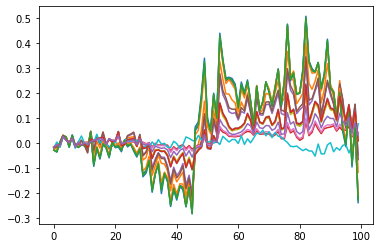

In [26]:
for _ in range(100):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        if  min(ps_fake[i])<-0.05 and min(ps_fake[i])>-1:
            plt.plot(list(range(100)),ps_fake[i]/2)

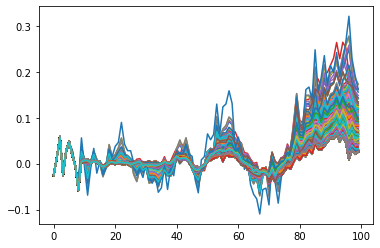

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

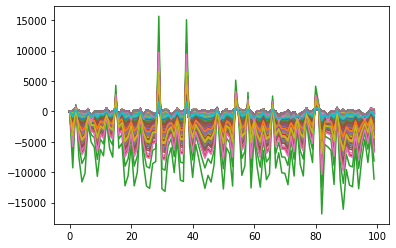

In [6]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

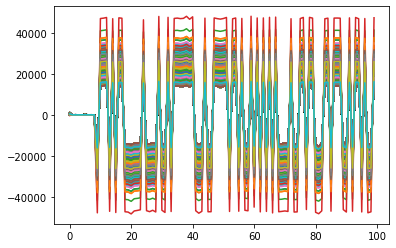

In [6]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

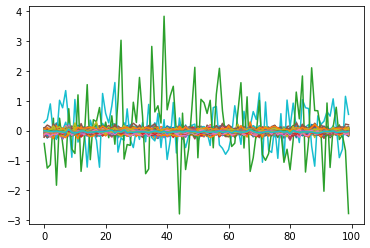

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

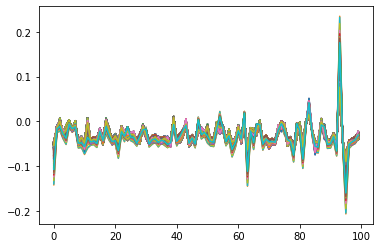

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

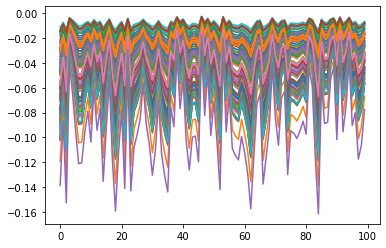

In [8]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i])

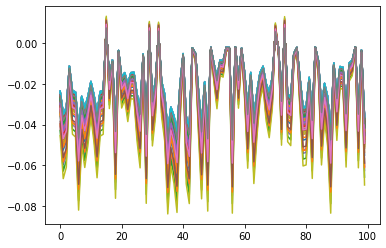

In [13]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i]/-1e10)

In [7]:
ps_fake

tensor([[2.9931e+08, 4.3878e+08, 4.0206e+08,  ..., 4.0381e+08, 4.1310e+07,
         4.5880e+08],
        [4.2777e+08, 6.2704e+08, 5.7457e+08,  ..., 5.7697e+08, 5.8824e+07,
         6.5672e+08],
        [3.0092e+08, 4.4114e+08, 4.0422e+08,  ..., 4.0597e+08, 4.1520e+07,
         4.6132e+08],
        ...,
        [3.0171e+08, 4.4229e+08, 4.0528e+08,  ..., 4.0703e+08, 4.1624e+07,
         4.6256e+08],
        [2.8306e+08, 4.1499e+08, 3.8025e+08,  ..., 3.8196e+08, 3.9181e+07,
         4.3336e+08],
        [5.1677e+08, 7.5750e+08, 6.9412e+08,  ..., 6.9701e+08, 7.1061e+07,
         7.9336e+08]])

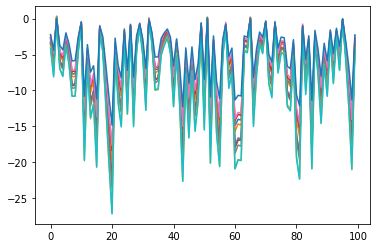

In [20]:
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i].cpu())
    if i == 10:
        break

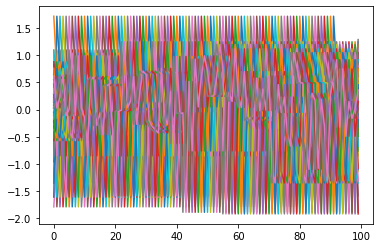

In [47]:
for data in dataloader:
    ps_real = data[0].permute(0,2,1).squeeze(-1)
    for i in range(len(ps_real)):
        plt.plot(list(range(100)),ps_real[i].cpu())

    break

In [43]:
ts_real = trade_strategy.get_strategy_PnL(ps_real).cpu()#,torch.ones_like(ps_real))
ts_fake = trade_strategy.get_strategy_PnL(ps_fake).cpu()#,torch.ones_like(ps_fake))

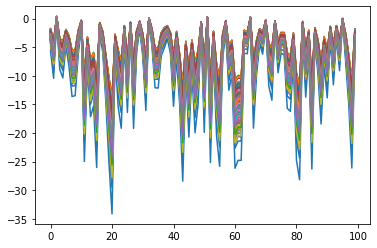

In [46]:
for i in range(len(ps_real)):
#     plt.plot(list(range(100)),ts_real[i])
    plt.plot(list(range(100)),ts_fake[i])

In [ ]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

## Results and visualizing stylized facts

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

In [56]:
t = torch.tensor([1.,5.,3.],requires_grad = True)
b = torch.tensor([1.,2.,3.]).reshape(-1,1)
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

tensor([1., 3., 2.])

In [57]:
result.backward()
t.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

In [25]:
t = torch.tensor([[1.,5.,3.],[1.,5.,3.],[1.,5.,3.]],requires_grad = True)
s =torch.cumsum(t,dim=1)
s

tensor([[1., 6., 9.],
        [1., 6., 9.],
        [1., 6., 9.]], grad_fn=<CumsumBackward0>)

In [12]:
(t>t).long()

tensor([0, 0, 0], device='cuda:0')

In [53]:
t.detach().cpu().cuda().cuda()

tensor([1., 5., 3.], device='cuda:0')

In [11]:
tanh = nn.Tanh()

In [13]:
tanh(t)

tensor([0.7616, 0.9999, 0.9951], device='cuda:0', grad_fn=<TanhBackward0>)

In [12]:
torch.arange(1,10)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
s[:,1:] - s[:,-1].reshape(-1,1)

tensor([[-3.,  0.],
        [-3.,  0.],
        [-3.,  0.]], device='cuda:0', grad_fn=<SubBackward0>)

In [20]:
z = torch.zeros(3).unsqueeze(1)
torch.cat((z,s),dim=1)

tensor([[0., 1., 6., 9.],
        [0., 1., 6., 9.],
        [0., 1., 6., 9.]], grad_fn=<CatBackward0>)

In [33]:
def running_mean(x, N):
    zeros = torch.zeros(x.size()[0]).unsqueeze(1)
    ma = torch.cat((zeros,x),dim=1)
    ma = torch.cumsum(ma,dim=1) 
#     print(ma)
#     print(ma[:,N:] - ma[:,:-N])
    ma = (ma[:,N:] - ma[:,:-N]) / float(N)
    ma = torch.cat((x[:,:N-1],ma),dim=1)
    return ma
running_mean(s,2)

tensor([[ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.]], grad_fn=<CumsumBackward0>)
tensor([[ 7., 15.],
        [ 7., 15.],
        [ 7., 15.]], grad_fn=<SubBackward0>)


tensor([[1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000]], grad_fn=<CatBackward0>)

In [8]:
torch.linspace(0,0, steps=(1,2))

TypeError: linspace(): argument 'steps' must be int, not tuple

In [7]:
torch.log(torch.tensor([1,2]))

tensor([0.0000, 0.6931])